# Derviving and implmenting resnet2resnet transformations

TODO: basically copy the abstract of the paper here

TODO: add some diagrams and visual and wordy understanding of what's going on

TODO: link to paper when published

TODO: add references to 231n pytorch tutorials (Justin Johnson's github) + the source code for convs, https://pytorch.org/docs/master/_modules/torch/nn/modules/conv.html as it's very instructive of how we will manipulate them

## Preamble
### Jupyter Notebook Config

Here's just some code to make matplotlib libraries etc play nice with jupyter notebooks. (So we just run the below code and don't worry about how it works).

This will setup plotting how we want it, make matplotlib and seaborn figures run inline and make imported library code auto-reload when changed.

The following code snippet was used in the assignments of [Stanford's cs231n](http://cs231n.stanford.edu/), and has been very useful!

In [1]:
# Some imports
import random
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import time

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Seaborn config
sns.set(color_codes=True)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Imports :)

In [2]:
# import the pytorch and numpy libraries we need now
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np

## Cuda
Change the following flag if you have a GPU and wish to use it.

In [13]:
use_gpu = False

## Building Zero And Identity Initializations
### Initializing the kernel

As a building block, we provide code that will take some convolutional kernal F, and then "widen" the filter with duplicated weights E. That is, given F of shape (C1, I, W, H) and a number of new filters C2 to add, we randomly initialize E with shape (C2, I, W, H) and return [F;E;E] of shape (C1+2\*C2, I, W, H). (N.B. we use ';' for concatenation).

We begin by implementing the standard Xavier and He initializations (1st cell) with some additinal options. In the 2nd cell we implement taking a filter [F] and extending the kernel to [F;E;E]. Note, that this also allows us to initialize filters of the form [E;E], by letting F be empty. We implement two functions that perform this concetenation in the 0th and 1st dimensions respectively (corresponding to the output channels and input channels for a convolutional kernal respectively).

In [3]:
def _conv_xavier_initialize(filter_shape, override_input_channels=None, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "He initialization".
    The weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/(n_in + n_out)).
    
    This is the initialization of choice for layers with non ReLU activations.
    
    The filter shape should be [output_channels, input_channels, width, height]. So here, n_in = input_channels 
    and n_out = width * height * output_channels.
    
    When "widening" an filter, from C1 output filters, to C1 + 2*C2 filters, then we want to initialize the 
    additional 2*C2 layers, as if there are C1+2*C2 filters in the output, and therefore we provide the 
    option to override the number of output filters.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization for
    :param override_output_channels: Override for the number of input filters in the filter_shape (optional)
    :param override_output_channels: Override for the number of output filters in the filter_shape (optional)
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    out_channels, in_channels, width, height = filter_shape
    if override_input_channels is not None:
        in_channels = override_input_channels
    if override_output_channels is not None:
        out_channels = override_output_channels
    filter_shape = (out_channels, in_channels, width, height)    
    
    scale = np.sqrt(2.0 / (width*height(in_channels + out_chanels))
    return scale * np.random.randn(*filter_shape).astype(np.float32) 
    
    

def _conv_he_initialize(filter_shape, override_input_channels=None, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "Xavier initialization".
    Each weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/n_in).
    
    This is the initialization of choice for layers with ReLU activations.
    
    The filter shape should be [output_channels, input_channels, width, height]. So here, n_in = input_channels.
    
    As the initization only depends on the number of inputs (the number of input channels), unlike Xavier 
    initialization, we don't need to be able to override the number of output_channels.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization 
    :param override_output_channels: Override for the number of input filters in the filter_shape (optional)
    :param override_output_channels: unused
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    out_channels, in_channels, width, height = filter_shape
    if override_input_channels is not None:
        in_channels = override_input_channels
    filter_shape = (out_channels, in_channels, width, height)    
                    
    scale = np.sqrt(2.0 / in_channels*width*height)
    return scale * np.random.randn(*filter_shape).astype(np.float32)




In [4]:
def _extend_filter_with_repeated_out_channels(extending_filter_shape, existing_filter=None, init_type='He', 
                                            alpha=1.0):
    """
    We want to expand filter by adding output channels with appropriately initialized weights.
    
    Let F be the 'existing_filter', with shape [C1,I,W,H]. Let extending_filter_shape be [2*C2,I,W,H]. 
    If the shape value that should be 2*C2 is odd or non-positive, then it's an error.
    The shape of the extended filter will be [C1+2*C2, I, W, H].
    
    We then want to initialize E of shape [C2,I,W,H], according to the given initialization, 
    and then we want to return the concatenation [F;E;alpha*E], where concatination is in the inconsistent 
    dimension.
    
    To make a fresh/new filter, with repeated weights, let 'existing_filter' be None, and it will 
    return just [E;alpha*E], as F is "empty". (Concatenation in the output channels dimension.)
    
    :param extending_filter_shape: The shape of the new portion of the filter to return. I.e. [2*C2,I,W,H]
    :param existing_filter: If not None, it must have shape [C1,I,W,H]. This is the existing filter.
    :param init_type: The type of initialization to use for new weights.
    :return: A filter of shape [C1+2*C2, I, W, H], which is the 'existing_filter' extended by 2*C2 output channels. 
            I.e. the filter [F;E;alpha*E]
    """
    # Unpack params input.
    twoC2, I, W, H = extending_filter_shape
    C2 = twoC2 // 2
    C1 = 0 if existing_filter is None else existing_filter.shape[0]
    
    # Error checking.
    if twoC2 % 2 != 0:
        raise Exception("The filter shape needs to be even to allow for repetition in it.")
    elif existing_filter is not None and (W != existing_filter.shape[2] 
        or H != existing_filter.shape[3] or I != existing_filter.shape[1]):
        raise Exception("Dimensions of 'extending_filter_shape' and 'existing_filter' are incompatible.")
    
    # Canvas for the new numpy array to return. Copy existing filter weights.
    canvas = np.zeros((C1+twoC2, I, W, H)).astype(np.float32)
    if existing_filter is not None:
        canvas[:C1,:,:,:] = existing_filter

    # Initialize the new weights, and copy that into the canvas (twice).
    new_channels_weights = None
    if init_type == 'He':
        new_channels_weights = _conv_he_initialize((C2,I,W,H))
    elif init_type == 'Xavier':
        new_channels_weights = _conv_xavier_initialize((C2,I,W,H), override_output_channels=C1+twoC2)
    else:
        raise Exception("Invalid initialization type specified. Please use 'He' or 'Xavier'.")
    
    canvas[C1:C1+C2,:,:,:] = new_channels_weights
    canvas[C1+C2:C1+twoC2,:,:,:] = alpha * new_channels_weights

    # Done :)
    return canvas



def _extend_filter_with_repeated_in_channels(extending_filter_shape, existing_filter=None, init_type='He', 
                                           alpha=1.0):
    """
    We want to expand filter by adding input channels with appropriately initialized weights.
    
    This time we are repeating/concatenating over the input channels rather than output channels. 
    They're nearly identical. 
    (There is/was code to extend both input and output channels at once, but it's overly complex to use here.)
    
    Let F be the 'existing_filter', with shape [C,I1,W,H]. Let extending_filter_shape be [C,2*I2,W,H]. 
    If the shape value that should be '2*I2' is odd or non-positive, then it's an error.
    We then want to initialize E of shape [C,I2,W,H], according to the given initialization, 
    and then we want to return the concatenation [F;E;alpha*E], where concatination is in the inconsistent 
    dimension.
    
    To make a fresh/new filter, with repeated weights, let 'existing_filter' be None, and it will 
    return just [E;alpha*E], as F is "empty". (Concatenation in the input channel dimension.)
    
    :param extending_filter_shape: The shape of the new portion of the filter to return. I.e. [C,2*I2,W,H]
    :param existing_filter: If not None, it must have shape [C,I1,W,H]. This is the existing filter.
    :param init_type: The type of initialization to use for new weights.
    :return: A filter, which is the 'existing_filter' extended by 2*I2 input channels. 
            I.e. the filter [F;E;alpha*E]
    """
    # Unpack params input.
    C, twoI2, W, H = extending_filter_shape
    I2 = twoI2 // 2
    I1 = 0 if existing_filter is None else existing_filter.shape[1]
    
    # Error checking.
    if twoI2 % 2 != 0:
        raise Exception("The filter shape needs to be even to allow for repetition in it.")
    elif existing_filter is not None and (W != existing_filter.shape[2] 
        or H != existing_filter.shape[3] or C != existing_filter.shape[0]):
        raise Exception("Dimensions of 'extending_filter_shape' and 'existing_filter' are incompatible.")
    
    # Canvas for the new numpy array to return. Copy existing filter weights.
    canvas = np.zeros((C, I1+twoI2, W, H)).astype(np.float32)
    if existing_filter is not None:
        canvas[:,:I1,:,:] = existing_filter

    # Initialize the new weights, and copy that into the canvas (twice).
    new_channels_weights = None
    if init_type == 'He':
        new_channels_weights = _conv_he_initialize((C,I2,W,H))
    elif init_type == 'Xavier':
        new_channels_weights = _conv_xavier_initialize((C,I2,W,H), overried_input_channels=I+twoI2)
    else:
        raise Exception("Invalid initialization type specified. Please use 'He' or 'Xavier'.")
    
    canvas[:,I1:I1+I2,:,:] = new_channels_weights
    canvas[:,I1+I2:I1+twoI2,:,:] = alpha * new_channels_weights

    # Done :)
    return canvas

## Putting together a zero initialization

We define a nn.Module called a "R2R_block", which is what we will use to denote any block that we can specify that it should be "zero initialized". Where zero initialized means that the output will be identically zero for any given input.

Now we can make a nn.Module involving multiple convolutional layers (in this case we will work with 2 for now), and initialize it so that the output is zero, for every input. This provides a "convolutional layer" (it's obviously more than just a single convolution) to be used as a building block in larger networks. 

One limitation is that the output of the block will be a fixed size, as the widenings are applied internally.

We don't provide any filter extending (althrough we implemented the numpy code necessary for it above), and we only initialize convolutions in a specific way. THe work for "widening" the network through training will be implemented later.

In [5]:
def _noise(shape, scale):
    return scale * np.random.randn(*shape).astype(np.float32)

In [6]:
class R2R_block_v1(nn.Module):
    """
    Defines a R2R block, version 1, this will be our first iteration and so we will make some (arbitrary) design 
    choices for now, just to make prototyping easier. The R2R block refers to a small block that can be 
    initialized such that the output is identically zero for any input.
    
    R2R block V1 consists of the following network layers/operations:
        (optional) max pool
        k1*k1 conv2d
        batchnorm
        activation function
        k2*k2 conv2d (with k2=1)
        
    Simplifying assumptions that we make for now:
        0. k1 = 3. It doesn't need to be.
        1. k2 = 1, it doesn't need to be.
        2. We don't actually want k1*k1 convolutions always, we need to have 1*7 and so on to implement inception 
            networks.
        3. We need to be able to extend the sizes of the filters at runtime. We compltely omit this here. This 
            will require some function to iterate over the layers and apply the function:
            layr, nxtLayr = r2r(layr, nxtLayr)
        4. More activations that just ReLU.
        5. Options for how to initialize new weights.
        6. Not just convolutional layers (linear also).
        7. Padding and stride are such that input's spatial dimensions are maintained.
        8. Obviously not just a two layer block, but, have a list of convolutions to apply/use
        
    Shape analysis (use [.;.]_i to denote concatenation in ith dimension):
        0. Given some input with shape [D,A,B], and ignoring any max pooling (assume it happens before the analysis).
        1. The first convolutional filter is initialized using [F1;F1]_0, where F1 is randomly initialized and of 
            shape [C,D,k1,k1]. So the filter [F1;F1] has shape [2*C,D,k1,k1].
        2. After applying the convolution (with kernel [F1;F1]) to the input (With shape [D,A,B]), the volume 
            now has shape [2*C,A,B]
        3. The second convolutional filter is initialized using [F2; -F2]_1, where F2 is randomly initialized with 
            shape [O,C,k2,k2]. So the filter [F2;-F2] has shape [O,2*C,k2,k2]
        4. The output volume will have shape [O,A,B], after the filter [F2;-F2] has been applied.
    """
    def __init__(self, input_channels, intermediate_channels, output_channels, 
                 add_max_pool=False, add_batch_norm=True, zero_initialize=True, noise_ratio=1e-3):
        """
        Initializes each of the layers in the R2R module, and initializes the variables appropriately. That is 
        if zero_initialize == True, then we initialize the network to have a constant zero output.
        
        In the 'shape analysis' above, input_channels, intermediate_channels and output_channels correspond to 
        the variables D, 2*C, O respectively.
        
        :param input_channels: THe number of input channels provided to the conv2d layer
        :param intermediate_channels: The number of output channels from the first conv2d layer, and the number 
                input to the 1*1 convolution
        :param output_channels: The number of channels output by the whole module
        :param add_max_pool: if we should add a max pool layer at the beginning
        :param add_batch_norm: if we should add a batch norm layer in the middle, before the activation function
        :param zero_initialize: should we initialize the module such that the output is always zero?
        :param noise_ratio: the amount of noise to add, as ratio (of the max init weight in the conv2d kernel) 
                (break symmetry)
        """
        # Superclass initializer
        super(R2R_block_v1, self).__init__()
    
        # Make the layers
        self.opt_max_pool = lambda x: x
        if add_max_pool:
            self.opt_max_pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(input_channels, intermediate_channels, kernel_size=3, padding=1)
        self.opt_batch_norm = lambda x: x 
        if add_batch_norm:
            self.opt_batch_norm = nn.BatchNorm2d(num_features=intermediate_channels)
        self.activation_function = F.relu
        self.conv2 = nn.Conv2d(intermediate_channels, output_channels, kernel_size=1)

        # If providing a zero initialization, do all of our repeated weight trickery!
        if zero_initialize:
            # Initialize the conv weights as appropriate, using the helpers and adding a small amount of noise
            conv1_filter_shape = (intermediate_channels, input_channels, 3, 3)
            conv1_filter_init = _extend_filter_with_repeated_out_channels(conv1_filter_shape, init_type='He')
            
            self.conv1.weight.data = Parameter(t.Tensor(conv1_filter_init))
            self.conv1.bias.data *= 0.0
            
            conv2_filter_shape = (output_channels, intermediate_channels, 1, 1)
            conv2_filter_init = _extend_filter_with_repeated_in_channels(conv2_filter_shape, init_type='He', 
                                                                       alpha=-1.0)
            
            self.conv2.weight.data = Parameter(t.Tensor(conv2_filter_init))
            self.conv2.bias.data *= 0.0
            
            # Initialize the batch norm variables so that the scale is one and the mean is zero
            if add_batch_norm:
                self.opt_batch_norm.weight.data = Parameter(t.Tensor(t.ones(intermediate_channels)))
                self.opt_batch_norm.bias.data = Parameter(t.Tensor(t.zeros(intermediate_channels)))
                
            
            
    def forward(self, x):
        """
        Forward pass of the module.
        If max pool and batch norm were not specified to be used, then self.opt_max_pool and/or self.opt_batch_norm 
        is a lambda identity function.
        
        :param x: The input tensor
        :return: The output from the module
        """
        x = self.opt_max_pool(x)
        x = self.conv1(x)
        x = self.opt_batch_norm(x)
        x = self.activation_function(x)
        x = self.conv2(x)
        return x

## Sanity checking what we've done so far

Now, lets run a few tests, as follows, to sanity check that everything that we've done so far works how we intended it to. These tests can be run in verbose mode (where the output of the last (random) input is also printed out, but, the output tends to be pretty large in that case, which is why allow for turning it off).

1. Set the noise to zero, and check that the output is zero for *any* input. Initially do this without batch norm.
2. Do the same, but with batch norm added.
2. Set the noise to a small variable, and check that the output is approximately zero (and non-symmetric).
4. Repeat test 3, with batch norm 
3. To gauge the effect that noise has, run the previous test, with a number of noise ratios.
5. Repreate test 5, with batch norm

In [7]:
# Verbose 
verbose = False

# Helper to make printing a little prettier :)
def indprint(string, tabs=0):
    print("\t" * tabs + string.replace('\n', '\n'+'\t'*tabs))
    
    
    
##########
# Test 1 #
##########
indprint("Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.")
r2r = R2R_block_v1(8,8,4, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=0.0)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,8,4,4)))
    output = r2r(rand_inputs)
    indprint("On iter %d, average output value magnitude is %f" % (i, t.sum(t.abs(output))), 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 2 #
##########
indprint("Test 2: same as test 1, with batch norm added, and max pooling added")
r2r = R2R_block_v1(4,2,2, add_max_pool=True, add_batch_norm=True, zero_initialize=True, noise_ratio=0.0)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,6,6)))
    output = r2r(rand_inputs)
    indprint("On iter %d, average output value magnitude is %f" % (i, t.sum(t.abs(output))), 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 3 #
##########
indprint("Test 3: same as test 1, with a small amount of noise added")
r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))
    output = r2r(rand_inputs)
    vals = (i, t.sum(t.abs(output)), t.sum(t.abs(output))/t.sum(t.abs(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 4 #
##########
indprint("Test 4: same as test 3, with batch norm")
r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=True, zero_initialize=True)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))
    output = r2r(rand_inputs)
    vals = (i, t.sum(t.abs(output)), t.sum(t.abs(output))/t.sum(t.abs(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    


##########
# Test 5 #
##########
indprint("Test 5: compare outputs, with the same input, given different noise ratios (no batch norm or max pool)")

# fixed input
rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))

# run with different lwevels of noise in the kernel
for noise in [10.0**i for i in range(-10, 2)]:
    r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=noise)
    output = r2r(rand_inputs)
    
    # analysis
    output_magnitudes = t.sum(t.abs(output))
    output_magnitudes_ratio = output_magnitudes/t.sum(t.abs(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)
    
if verbose:
    print('\n' * 4)
    


##########
# Test 6 #
##########
indprint("Test 6: same as test 5, with batch norm added")

# fixed input
rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))

# run with different lwevels of noise in the kernel
for noise in [10.0**i for i in range(-10, 2)]:
    r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=noise)
    output = r2r(rand_inputs)
    
    # analysis
    output_magnitudes = t.sum(t.abs(output))
    output_magnitudes_ratio = output_magnitudes/t.sum(t.abs(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)

Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.
	On iter 0, average output value magnitude is 0.000004
	On iter 1, average output value magnitude is 0.000006
	On iter 2, average output value magnitude is 0.000006
	On iter 3, average output value magnitude is 0.000007
	On iter 4, average output value magnitude is 0.000006
	On iter 5, average output value magnitude is 0.000007
	On iter 6, average output value magnitude is 0.000006
	On iter 7, average output value magnitude is 0.000007
	On iter 8, average output value magnitude is 0.000007
	On iter 9, average output value magnitude is 0.000005
Test 2: same as test 1, with batch norm added, and max pooling added
	On iter 0, average output value magnitude is 0.000000
	On iter 1, average output value magnitude is 0.000000
	On iter 2, average output value magnitude is 0.000000
	On iter 3, average output value magnitude is 0.000000
	On iter 4, average output value magnitude is

### Arriving at a identity initialization through residual connections

Now that we can initialize a convolutional stack to have a constant zero input (initialize the last two layers as we did above for any stack), we can wrap it in a residual block, thus providing an identity initialization of that residual block.

When we add a residual connection, our neural network (block) learns a function $F(x)$, and the output of the residual block is $h(x)=x+F(x)$. As we can initialize $F$ such that for all $x$ we have $F(x)=0$, then we have that $h(x)=x$ for all x.

In [8]:
class R2R_residual_block_v1(nn.Module):
    """
    A small residual block to be used for mnist/cifar10 tests. This is reletively simple, and is just the same 
    as building a small network in PyTorch, using "R2R_Block_v1" as one of the layers.
    
    It consists one set of convolutional layers (not multiple sizes of convolutions like Inception ResNet)
    It has the following architecture:
        Conv2D
        BatchNorm
        ReLU
        Conv2D
        BatchNorm
        ReLU
        R2R_block_v1         <- can chose to initialize so that the output is zero (and this block is an identity transform)
            Conv2D          
            BatchNorm
            ReLU
            Conv2D
            (implicit linear activation)
        
        + residual connection
        
    To deal with dimensionality issues, we use zero padding for the residual connection.
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=0.0):
        """
        Initialize the filters, optionally making this identity initialized.
        All convolutional filters have the same number of output channels
        """
        # Superclass initializer
        super(R2R_residual_block_v1, self).__init__()
    
        self.input_channels = input_channels
        self.noise_ratio = noise_ratio
        
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=output_channels)
        self.relu = F.relu
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.r2r = R2R_block_v1(output_channels, output_channels, output_channels, 
                                zero_initialize=identity_initialize, noise_ratio=noise_ratio)
        
        
        
    def forward(self, x):
        """
        Forward pass through this residual block
        
        :param x: the input
        :return: THe output of applying this residual block to the input
        """
        # Forward pass through residual part of the network
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.r2r(x)
        
        # add residual connection (implicit zero padding)
        out = x
        out[:,:self.input_channels] += res
        
        return out        

### More sanity checks

So now we just do one more sanity checks, which involves checking if we did indeed define an itentity operator above. 

In [9]:
verbose = False

##########
# Test 7 #
##########
indprint("Test 7: Check that the identity resnet module is indeed an identity function.")
res_block = R2R_residual_block_v1(2,4)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,2,5,5)))
    output = res_block(rand_inputs)
    indprint("On iter %d, average difference between input and output is %f" 
             % (i, t.sum(t.abs(output[:,:2] - rand_inputs))), 1)
    
if verbose:
    indprint("Input:", 1)
    indprint("%s" % rand_inputs, 1)
    indprint("Output:", 1)
    indprint("%s" % output, 1)
    indprint("Diff on common dim:s", 1)
    indprint("%s" % (output[:,:2]-rand_inputs), 1)

Test 7: Check that the identity resnet module is indeed an identity function.
	On iter 0, average difference between input and output is 0.000001
	On iter 1, average difference between input and output is 0.000001
	On iter 2, average difference between input and output is 0.000001
	On iter 3, average difference between input and output is 0.000001
	On iter 4, average difference between input and output is 0.000001
	On iter 5, average difference between input and output is 0.000000
	On iter 6, average difference between input and output is 0.000001
	On iter 7, average difference between input and output is 0.000001
	On iter 8, average difference between input and output is 0.000001
	On iter 9, average difference between input and output is 0.000001


### Training a small netowork, with 3 resnet modules, 3 max pools, and a fc output

To 'cap off' the "Building Zero And Identity Initializations" section, we're going to build a small residual block, that we can identity initialize. Then we're going to stack a few of these residual blocks together, and train a classifier on CIFAR-10 to sanity check that we can indeed still learn when identity initializations are used.

The first cell below defines a training loop used to evaluate our models; the second cell defines our small ResNet which we can optionally initialized the convolutional part of the network; the third cell runs the training loops a few times, evaluating the networks on Mnist; and the fourth cell will print out some graphs displaying the results, and should indicate if we "can still learn when using an identity initialization". 

In [16]:
# compute the accuracy of a prediction
def accuracy(prediction, target):
    _, pred_classes = t.max(prediction, 1)
    _, actual_classes = t.max(target, 1)
    return t.mean((pred_classes == actual_classes).type(t.float))

# Evaluate a model
def evaluate(model, dataset):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 500 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [19]:
# small network for MNist classes. This just simply strings together 3 residual blocks, with max pools between them
class Mnist_Resnet_v1(nn.Module):
    def __init__(self, identity_initialize=True):
        # Superclass initializer
        super(Mnist_Resnet_v1, self).__init__()
        
        # Make the three conv layers, with three max pools
        self.resblock1 = R2R_residual_block_v1(input_channels=1, 
                                               output_channels=16, 
                                               identity_initialize=identity_initialize) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]
        self.resblock2 = R2R_residual_block_v1(input_channels=16, 
                                               output_channels=32, 
                                               identity_initialize=identity_initialize) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]
        self.resblock3 = R2R_residual_block_v1(input_channels=32, 
                                               output_channels=64, 
                                               identity_initialize=identity_initialize) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(4*4*64, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*64))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x

In [20]:
# load mnist dataset (with some logic to add the current directory to pythons path variable)
import os
import sys
dataset_module_path = os.path.abspath(os.path.join('.'))
if dataset_module_path not in sys.path:
    sys.path.append(dataset_module_path)
from dataset import MnistDataset
from dataset import DatasetCudaWrapper

# Make a Mnist dataset, appropriately returning cuda/non-cuda variables 
dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)

# run our initialization 5 times
our_init_results = []
our_init_results_val = []
times = []
for i in range(5):
    model = Mnist_Resnet_v1(True)
    if use_gpu: 
        model = model.cuda()
        
    start_time = time.time()
    train_acc, val_acc = evaluate(model, dataset)
    elapsed_time = time.time() - start_time
    del model
    
    our_init_results.append(train_acc)
    our_init_results_val.append(val_acc)
    times.append(elapsed_time)

our_init_mean_time = np.mean(times)
our_init_stddev_time = np.std(times)
    
# run he initialization 5 times
he_init_results = []
he_init_results_val = []
for i in range(5):
    model = Mnist_Resnet_v1(False)
    if use_gpu:
        model = model.cuda()
        
    train_acc, val_acc = evaluate(model, dataset)
    del model
    he_init_results.append(train_acc)
    he_init_results_val.append(val_acc)


Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.078125, Current val: 0.046875.
(Iter 10). Current train: 0.125000, Current val: 0.054688.
(Iter 20). Current train: 0.093750, Current val: 0.125000.
(Iter 30). Current train: 0.125000, Current val: 0.117188.
(Iter 40). Current train: 0.109375, Current val: 0.109375.
(Iter 50). Current train: 0.421875, Current val: 0.320312.
(Iter 60). Current tr

(Iter 460). Current train: 0.984375, Current val: 0.960938.
(Iter 470). Current train: 0.984375, Current val: 0.976562.
(Iter 480). Current train: 0.953125, Current val: 0.945312.
(Iter 490). Current train: 0.984375, Current val: 0.953125.
(Iter 500). Current train: 0.968750, Current val: 0.984375.
(Iter 510). Current train: 0.984375, Current val: 0.976562.
(Iter 520). Current train: 1.000000, Current val: 0.984375.
(Iter 530). Current train: 1.000000, Current val: 0.945312.
(Iter 540). Current train: 0.968750, Current val: 0.992188.
(Iter 550). Current train: 0.953125, Current val: 0.953125.
(Iter 560). Current train: 1.000000, Current val: 1.000000.
(Iter 570). Current train: 0.984375, Current val: 0.976562.
(Iter 580). Current train: 1.000000, Current val: 0.984375.
(Iter 590). Current train: 1.000000, Current val: 0.960938.
(Iter 600). Current train: 0.953125, Current val: 0.992188.
(Iter 610). Current train: 0.921875, Current val: 0.984375.
(Iter 620). Current train: 0.984375, Cur

(Iter 210). Current train: 0.906250, Current val: 0.929688.
(Iter 220). Current train: 0.937500, Current val: 0.945312.
(Iter 230). Current train: 0.953125, Current val: 0.906250.
(Iter 240). Current train: 0.984375, Current val: 0.953125.
(Iter 250). Current train: 0.953125, Current val: 0.960938.
(Iter 260). Current train: 0.953125, Current val: 0.937500.
(Iter 270). Current train: 0.968750, Current val: 0.937500.
(Iter 280). Current train: 0.937500, Current val: 0.960938.
(Iter 290). Current train: 0.937500, Current val: 0.929688.
(Iter 300). Current train: 0.953125, Current val: 0.929688.
(Iter 310). Current train: 0.921875, Current val: 0.921875.
(Iter 320). Current train: 0.984375, Current val: 0.929688.
(Iter 330). Current train: 0.968750, Current val: 0.921875.
(Iter 340). Current train: 0.968750, Current val: 0.945312.
(Iter 350). Current train: 0.953125, Current val: 0.937500.
(Iter 360). Current train: 0.937500, Current val: 0.976562.
(Iter 370). Current train: 0.968750, Cur

(Iter 770). Current train: 0.953125, Current val: 0.945312.
(Iter 780). Current train: 0.968750, Current val: 0.960938.
(Iter 790). Current train: 0.937500, Current val: 0.968750.
(Iter 800). Current train: 0.984375, Current val: 0.976562.
(Iter 0). Current train: 0.078125, Current val: 0.140625.
(Iter 10). Current train: 0.140625, Current val: 0.210938.
(Iter 20). Current train: 0.109375, Current val: 0.203125.
(Iter 30). Current train: 0.265625, Current val: 0.117188.
(Iter 40). Current train: 0.156250, Current val: 0.218750.
(Iter 50). Current train: 0.234375, Current val: 0.234375.
(Iter 60). Current train: 0.421875, Current val: 0.398438.
(Iter 70). Current train: 0.515625, Current val: 0.453125.
(Iter 80). Current train: 0.437500, Current val: 0.539062.
(Iter 90). Current train: 0.640625, Current val: 0.601562.
(Iter 100). Current train: 0.578125, Current val: 0.656250.
(Iter 110). Current train: 0.750000, Current val: 0.734375.
(Iter 120). Current train: 0.796875, Current val: 0

(Iter 520). Current train: 0.984375, Current val: 0.960938.
(Iter 530). Current train: 0.968750, Current val: 0.953125.
(Iter 540). Current train: 0.984375, Current val: 0.976562.
(Iter 550). Current train: 0.937500, Current val: 0.984375.
(Iter 560). Current train: 0.937500, Current val: 0.960938.
(Iter 570). Current train: 0.953125, Current val: 0.984375.
(Iter 580). Current train: 1.000000, Current val: 0.968750.
(Iter 590). Current train: 1.000000, Current val: 0.984375.
(Iter 600). Current train: 1.000000, Current val: 0.976562.
(Iter 610). Current train: 1.000000, Current val: 0.992188.
(Iter 620). Current train: 0.968750, Current val: 0.976562.
(Iter 630). Current train: 0.984375, Current val: 0.968750.
(Iter 640). Current train: 0.984375, Current val: 0.976562.
(Iter 650). Current train: 0.968750, Current val: 0.968750.
(Iter 660). Current train: 1.000000, Current val: 0.937500.
(Iter 670). Current train: 0.984375, Current val: 0.984375.
(Iter 680). Current train: 1.000000, Cur

(Iter 270). Current train: 0.937500, Current val: 0.960938.
(Iter 280). Current train: 0.984375, Current val: 0.976562.
(Iter 290). Current train: 0.937500, Current val: 0.992188.
(Iter 300). Current train: 0.984375, Current val: 0.968750.
(Iter 310). Current train: 0.937500, Current val: 0.968750.
(Iter 320). Current train: 0.953125, Current val: 0.960938.
(Iter 330). Current train: 0.984375, Current val: 0.992188.
(Iter 340). Current train: 0.968750, Current val: 0.929688.
(Iter 350). Current train: 0.937500, Current val: 0.960938.
(Iter 360). Current train: 0.984375, Current val: 0.953125.
(Iter 370). Current train: 0.968750, Current val: 0.992188.
(Iter 380). Current train: 0.953125, Current val: 1.000000.
(Iter 390). Current train: 0.937500, Current val: 0.984375.
(Iter 400). Current train: 0.937500, Current val: 0.984375.
(Iter 410). Current train: 0.968750, Current val: 0.984375.
(Iter 420). Current train: 0.984375, Current val: 0.968750.
(Iter 430). Current train: 0.968750, Cur

/media/michael/DATA1/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/media/michael/DATA1/anaconda/envs/cs231n/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


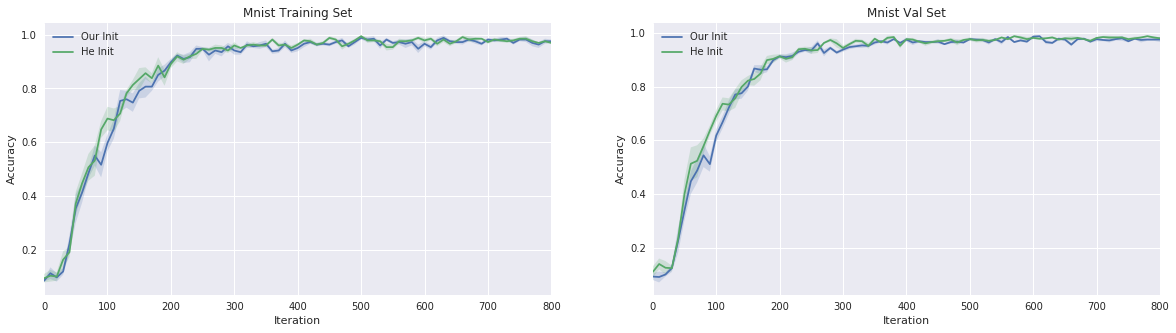

In [21]:
# Plot the results of the above tests with confidence intervals
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
sns.tsplot(data=our_init_results, time=xaxis, condition="Our Init")
sns.tsplot(data=he_init_results, time=xaxis, color="g", condition="He Init")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=our_init_results_val, time=xaxis, condition="Our Init")
sns.tsplot(data=he_init_results_val, time=xaxis, color="g", condition="He Init")

## Implementing R2WiderR and R2DeeperR

Now that we've shown that identity intiializations can actually do well, we have some sort of basis to believe that our deepening transforms will actually work. 

Now we move onto writing code that will widen the volume of a single hidden layer (by editing the input and output convolutions to that layer) such that we preserve the networks transform. 

So now we will now implement our widening transform and deepen transforms in this section.


### Implementing Filter Widening Logic

We begin by defining functions to perform widening (at a tensor level). As this will be needed for widening the internal tensors of Batch Norm.

In [174]:
def _zero_pad_1d(old_val, new_params):
    """
    Zero pads an old tensor to match the new number of outputs
    
    :param old_val the old torch tensor to zero pad
    :param new_params: the number of new params needed
    :return: a new, padded tensor
    """
    old_len = old_val.size()[0]
    canvas = t.zeros((old_len+new_params,))
    canvas[:old_len] = old_val
    return canvas



def _one_pad_1d(old_val, new_params):
    """
    One pads an old tensor to match the new number of outputs
    
    :param old_val the old torch tensor to one pad
    :param new_params: the number of new params needed
    :return: a new, padded tensor
    """
    old_len = old_val.size()[0]
    canvas = t.ones((old_len+new_params,))
    canvas[:old_len] = old_val
    return canvas



def _widen_hidden_volume(prev_kernel, prev_bias, next_kernel, extra_channels=0, init_type='He'):
    """
    This is an implementation of our "R2WiderR". 
    
    This function will widen a single hidden volume as part of a CNN. To widen the volume, we need to 
    add additional output filters to the kernel before this volume. Then, we also need to add additonal 
    input filters to the kernel after this volume. 
    
    Having written '_extend_filter_with_repeated_out_channels' and '_extend_filter_with_repeated_in_channels'
    very generally, we can piggyback off that prior work. We set alpha=-1.0 in the repeated channels of 
    the next kernel, so that initially the new channels in the volume don't change the network output at all.
    (See paper for more details.)
    
    :param prev_kernel: The PyTorch Tensor for the kernel of the convolution that computes the hidden 
            volume that we are extending. (I.e. the kernel preceeding the volume being extended.)
    :param prev_bias: The PyTorch Tensor for the bias of the convolution preceeding the volume being extended.
    :param next_kernel: The PyTorch Tensor for the kernel of the convolution used after this volume.
    :return: new_prev_kernel, new_prev_bias, new_next_kernel. Which are all PyTorch Tensors to be appropriately 
            set allocated as parameters in the networks.
    """
    _extend_filter_with_repeated_out_channels(extending_filter_shape, existing_filter=None, init_type='He', 
                                            alpha=1.0):
    _extend_filter_with_repeated_in_channels(extending_filter_shape, existing_filter=None, init_type='He', 
                                           alpha=1.0)
    # Compute new shapes needed
    
    prev_kernel_extension_shape = (prev_)
    
    # Compute the new kernels and bias, accounting for the new 
    new_prev_kernel = 
    new_prev_bias = 
    new_next_kernel = 
    
    # Doneee :)
    return new_prev_kernel, new_prev_bias, new_next_kernel
    
    
# def _widen_kernel_with_repeated_in_repeated_output(old_kernel, old_bias, extra_in_channels=0, 
#                                                    extra_out_channels=0, repeated_in=True, 
#                                                    repeated_out=True, init_type='He'):
#     """
#     A revised version of the logic to widen a kernel. We pass in the old kernel, the number of channels 
#     extended in a convolution before it (zero if the convolution before it hasn't been widened), and 
#     the number of new channels for the output.
    
#     If the old shape was [Ou,I,W,H] and the new shape is [Ou2,I2,W,H], so Ou2 is the new number of output 
#     channels and Ou is the old number of output channels, when we initialize as follows:
    
#     Letting hOu = (Ou2-Ou)/2
#     and hI = (I2-I)/2
#     and r1, r2, r3 are appropriately randomly initialized 
    
#         In \ Out |      0:Ou      |    Ou:Ou+hOu    |   Ou+hOu:Ou2    
#         -------------------------------------------------------------
#              0:I |  old[0:Ou,0:I] |  r1[0:hOu,0:I]  |  r1[0:hOu,0:I]  
#         -------------------------------------------------------------       
#           I:I+hI |  r2[0:Ou,0:hI] |  r3[0:hOu,0:hI] |  r3[0:hOu,0:hI] 
#         -------------------------------------------------------------
#          I+hI:I2 | -r2[0:Ou,0:hI] | -r3[0:hOu,0:hI] | -r3[0:hOu,0:hI]   
         
         
#     Note, if we change either repeated_input or repeated_output, then, we no longer have a function preserving
#     transfom. And we ignore the above grid.
    
#     :param old_kernel: the old kernel of the convolution layer (of shape (A,B,W,H))
#     :param old_bias: the old bias of the convolution layer (of shape (A,))
#     :param extra_in_channels: the number of new channels being input to this layer (A2-A)
#     :param extra_out_channels: the number of new channels being output from this layer (B2-B)
#     :param repeated_in: if we want to handle repeated input (of NEW input channels)
#     :param repeated_out: if we want to make the NEW output channels repeated 
#     :param init_type: The type of initialization to use for the kernel
#     :return: A new, larger filter and bias. (Initialized appropriately for a function preserving transform)
#     """
#     if extra_in_channels % 2 != 0 or extra_out_channels % 2 != 0:
#             # TODO: log an appropraite error message
#             raise Exception()
    
#     # compute values related to kernel size
#     Ou, I, W, H = old_kernel.size()
#     hOu = extra_out_channels // 2
#     hI = extra_in_channels // 2
#     total_new_in_channels = I + extra_in_channels
#     total_new_out_channels = Ou + extra_out_channels
    
#     # init function
#     init = None
#     if init_type == "He":
#         init = lambda shape: t.tensor(_conv_he_initialize(shape, total_new_in_channels, total_new_out_channels))
#     elif init_type == "Xavier":
#         init = lambda shape: t.tensor(_conv_xavier_initialize(shape, total_new_in_channels, total_new_out_channels))
    
#     # compute r1, r2, r3 as above.
#     if hOu > 0:
#         r1 = init((hOu,  I, W, H)) 
#     if hI > 0:
#         r2 = init(( Ou, hI, W, H))
#     if hOu > 0 and hI > 0:
#         r3 = init((hOu, hI, W, H))
    
#     # make a canvas and fill it appropriately
#     # ignore repetitions appropriately if either negate_repeated_new_input, repeat_new_output is false
#     canvas = t.zeros((total_new_out_channels, total_new_in_channels, W, H))
    
#     # top left four squares
#     canvas[:Ou, :I] = old_kernel
#     if hOu > 0:
#         canvas[Ou:Ou+hOu, :I] = r1
#     if hI > 0:
#         canvas[:Ou, I:I+hI] = r2
#     if hOu > 0 and hI > 0:
#         canvas[Ou:Ou+hOu, I:I+hI] = r3
    
#     # bottom left two squares
#     if hI > 0:
#          canvas[:Ou, I+hI:I+2*hI] = -r2 if repeated_in else init((Ou, hI, W, H))
#     if hOu > 0 and hI > 0:
#         canvas[Ou:Ou+hOu, I+hI:I+2*hI] = -r3 if repeated_in else init((hOu, hI, W, H))
        
#     # right three squares    
#     if hOu > 0:
#         canvas[Ou+hOu:Ou+2*hOu] = canvas[Ou:Ou+hOu] if repeated_out else init((hOu, I+2*hI, W, H))
        
#     # Bias just needs to be zero padded appropriately
#     return canvas, _zero_pad_1d(old_bias, extra_out_channels)



# def _widen_kernel_with_repreated_in(old_kernel, old_bias, extra_input_channels, init_type='He'):
#     """
#     Code for repeated_in and repreated_out breaks if one of the values is zero. 
#     So for just repeated in, can't just pass in a zero, and have to 
#     """



# def _widen_kernel_with_repeated_out(old_kernel, old_bias, extra_output_channels, init_type='He'):
#     """
#     This just passes off to the widen function we've already written, and combines is with extending the bias
#     This extends the filter, assuming a FIXED input size, to increase the number of output filters
    
#     :param: 
    
#     :param old_kernel: the old kernel of the convolution layer
#     :param old_bias: the old bias of the convolution layer 
#     :param extra_output_channels: the number of new channels being output from this layer
#     :param init_type: The type of init to use for the initialization
#     :return: The new kernel, same as the old, with more output filters (repeated as needed for a function preserving transform)
#     """
#     if extra_output_channels % 2 != 0:
#             # TODO: log an appropraite error message
#             raise Exception()
            
#     # compute values related to kernel size
#     Ou, I, W, H = old_kernel.size()
#     total_new_in_channels = I + extra_in_channels
#     total_new_out_channels = Ou + extra_out_channels
#     extending_filder_shape = (total_new_out_channels, total_new_in_channels, W, H)
    
#     # make new kernel and bias
#     new_kernel = _extend_filter_with_repeated_output(extending_filter_shape, 
#                                                    existing_filter=old_kernel.numpy(), 
#                                                    init_type=init_type)
#     new_kernel = t.tensor(new_kernel)
#     new_bias = _pad_bias(old_bias, total_new_out_channels)
    
#     return new_kernel, new_bias

### Implementing R2WiderR, within R2R_residual_block_v2

Make R2R_residual_block v2, that makes use of the filter widening functions written above. v2 subclasses v1, and adds a widen operation

In [444]:
class R2R_residual_block_v2(R2R_residual_block_v1):
    """
    A small residual block to be used for mnist/cifar10 tests.
    
    Extends v1, and adds a widen operation.
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=1.0e-8):
        """
        Pass off to the superclass initializer
        """
        super(R2R_residual_block_v2, self).__init__(input_channels, output_channels, identity_initialize, noise_ratio)
        
        
    def widen(self, num_channels, function_preserving=True):
        """
        Widens the network appropriately (widens each of the filters). This is slightly hacky, as really 
        we want to call self.r2r.widen() rather than manipulating the r2r block ourselves. We will do this 
        in the final version.
        
        :param num_channels: The number of channels to add to every 
        :param function_preserving: If the widen should be a function preserving transform
        """ 
        # update new conv variable 
        self.conv1 = self._extend_conv(self.conv1, 0, num_channels, function_preserving) # don't extend input!
        self.conv2 = self._extend_conv(self.conv2, num_channels, num_channels, function_preserving)
        self.r2r.conv = self._extend_conv(self.r2r.conv, num_channels, num_channels, function_preserving)
        self.r2r.reduction = self._extend_conv(self.r2r.reduction, num_channels, 0, function_preserving, # don't extend output!
                                               kernel_size=1, padding=0)
        
        # update new bn variables
        self.bn1 = self._extend_batch_norm(self.bn1, num_channels)
        self.bn2 = self._extend_batch_norm(self.bn2, num_channels)
        self.r2r.batch_norm = self._extend_batch_norm(self.r2r.batch_norm, num_channels)
    
    
    def _extend_conv(self, conv, extra_channels_in=0, extra_channels_out=0, function_preserving=True, kernel_size=3, padding=1):
        """
        Combines all of the logic to extend conv, new convolution module. We create a new conv module, and 
        initialize it so that the filter is appropriately 'extended' from the old convolution module, 
        appropriately implementing the widening transform
        
        :param conv: The nn.Module convolution subclass instance to extend
        :param extra_channels_in: The number of extra channels in when widening the convolution
        :param extra_channels_out: The number of extra channels out when widening the convolution
        :param function_preserving: Should the convolution be extended in such a way that it preserves the function
        :returns: A new convolution, which is the result of this widen transform
        """
        # make the new conv module
        new_conv = nn.Conv2d(conv.in_channels+extra_channels_in, 
                             conv.out_channels+extra_channels_out, 
                             kernel_size=kernel_size, 
                             padding=padding)
        
        # shorthand, for long function name
        widen = _widen_kernel_with_repeated_in_repeated_output
        
        # Compute new kernel and bias
        new_kernel, new_bias = widen(old_kernel = conv.weight.data, 
                                     old_bias = conv.bias.data, 
                                     extra_in_channels = extra_channels_in,
                                     extra_out_channels = extra_channels_out,
                                     repeated_in=function_preserving, 
                                     repeated_out=function_preserving)
        
        # Add noise
        max_entry = t.max(t.abs(new_kernel))
        noise_scale = self.noise_ratio * max_entry
        noise = t.tensor(np.random.randn(*(new_kernel.size())).astype(np.float32))
        if new_kernel.is_cuda:
            noise = noise.cuda()
        new_kernel += self.noise_ratio * noise
        
        # Assign 
        new_conv.weight.data = Parameter(new_kernel)
        new_conv.bias.data = Parameter(new_bias)
        
        return new_conv
    
        
    def _extend_batch_norm(self, bn, num_channels):
        """
        Combines all of the logic to IN PLACE extend the 'bn' batch norm nn.Module appropriately to 
        extend a batch norm layer, and reset all of it's params appropriately for the widening transform.
        
        :param bn: The nn.Module batch norm subclass instance to extend
        :param num_channels: The number of extra channels (input and output) from this layer
        """
        # new batch norm module
        new_bn = nn.BatchNorm2d(num_features=bn.num_features + num_channels)
        
        # Zero/One pad the each of the sets of parameters maintained by batch norm layers appropriately
        new_scale = _one_pad_1d(bn.weight.data, num_channels)
        new_shift = _zero_pad_1d(bn.bias.data, num_channels)
        new_running_mean = _zero_pad_1d(bn.running_mean.data, num_channels)
        new_running_var = _zero_pad_1d(bn.running_var.data, num_channels)
        
        # Assign in the Module appropriately
        new_bn.weight.data = Parameter(new_scale)
        new_bn.bias.data = Parameter(new_shift)
        new_bn.running_mean.data = Parameter(new_running_mean)
        new_bn.running_var.data = Parameter(new_running_var)
        
        return new_bn
        
        

### Define the Mnist_Resnet_v2, using the v2 residual blocks

This includes a widen function, that just calls widen on all of the R2R_residual_block v2's. We provide a flag 'thin', which we should use to make a thinner network, which when widened, will be the same size. This isn't coded particularly elegantly, but it's just a trial run.

Note that there's a lot of things that we wouldn't want in a final implementation. Such as not being able to specify how much to widen the network by

In [176]:
class Mnist_Resnet_v2(nn.Module):
    def __init__(self, identity_initialize=True, thin=False, noise_ratio=1.0e-8):
        # Superclass initializer
        super(Mnist_Resnet_v2, self).__init__()
        
        # Make the three conv layers, with three max pools
        i, o = (1, 16) if not thin else (1, 8)
        self.resblock1 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]     
        i, o = (16, 32) if not thin else (8, 16)
        self.resblock2 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]
        i, o = (32, 64) if not thin else (16, 32)
        self.resblock3 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.final_conv_channels = 64 if not thin else 32
        self.linear1 = nn.Linear(4*4*self.final_conv_channels, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*self.final_conv_channels))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x
    
    def widen(self):
        self.resblock1.widen(8)
        self.resblock2.widen(16)
        self.resblock3.widen(32)
 

### Sanity checks for the widen transform

In [177]:
# Make a mnist resnet v2
model = Mnist_Resnet_v2(thin=True, noise_ratio=0.0)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen and check that the outputs are (almost) identical
model.widen()
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Params in model before widen: 165826
Params in model after widen: 246082


### Testing the widen transfrom on mnist, and evaluating it

Extend the evaluate function to take an iteration number to call deepen/widen on the model. Then run evaluate on the thin version of Mnist Resnet v2, and the widen after a few training iterations. We compare this against just the normal training of Mnist to see how it does.

In [178]:
# Evaluate a model
def evaluate(model, dataset, widen=-1, deepen=-1):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 300 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the R2R transform
        if i ==  widen:
            model.widen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
        if i == deepen: 
            model.deepen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
            
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [185]:
# run our init, with widen at 60,120,180,240 iters
widen_results = {}
widen_results_val = {}
widen_times = {}

dataset = DatasetCudaWrapper(MnistDataset(64))

for widen in [60,120,180,240]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Mnist_Resnet_v2(thin=True)
        model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, widen=widen)
        elapsed_time = time.time() - start_time
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    widen_results[widen] = results
    widen_results_val[widen]= results_val
    widen_times[widen] = (np.mean(times), np.std(times))

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.218750, Current val: 0.101562.
(Iter 10). Current train: 0.046875, Current val: 0.101562.
(Iter 20). Current train: 0.078125, Current val: 0.109375.
(Iter 30). Current train: 0.140625, Current val: 0.085938.
(Iter 40). Current train: 0.031250, Current val: 0.125000.
(Iter 50). Current train: 0.218750, Current val: 0.265625.
(Iter 60). Current train: 0.281250, C

(Iter 460). Current train: 0.890625, Current val: 0.976562.
(Iter 470). Current train: 0.937500, Current val: 0.976562.
(Iter 480). Current train: 0.937500, Current val: 0.976562.
(Iter 490). Current train: 0.937500, Current val: 0.945312.
(Iter 500). Current train: 0.953125, Current val: 0.945312.
(Iter 510). Current train: 0.968750, Current val: 0.976562.
(Iter 520). Current train: 0.984375, Current val: 0.953125.
(Iter 530). Current train: 0.937500, Current val: 0.960938.
(Iter 540). Current train: 0.968750, Current val: 0.960938.
(Iter 550). Current train: 0.968750, Current val: 0.960938.
(Iter 560). Current train: 0.937500, Current val: 0.984375.
(Iter 570). Current train: 0.968750, Current val: 1.000000.
(Iter 580). Current train: 0.984375, Current val: 0.984375.
(Iter 590). Current train: 0.968750, Current val: 0.968750.
(Iter 600). Current train: 0.968750, Current val: 0.937500.
(Iter 610). Current train: 0.953125, Current val: 0.960938.
(Iter 620). Current train: 0.968750, Cur

(Iter 210). Current train: 0.937500, Current val: 0.937500.
(Iter 220). Current train: 0.937500, Current val: 0.898438.
(Iter 230). Current train: 0.906250, Current val: 0.960938.
(Iter 240). Current train: 0.890625, Current val: 0.945312.
(Iter 250). Current train: 0.906250, Current val: 0.937500.
(Iter 260). Current train: 0.937500, Current val: 0.945312.
(Iter 270). Current train: 0.875000, Current val: 0.984375.
(Iter 280). Current train: 0.984375, Current val: 0.953125.
(Iter 290). Current train: 0.937500, Current val: 0.914062.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.921875, Current val: 0.976562.
(Iter 320). Current train: 0.968750, Current val: 0.953125.
(Iter 330). Current train: 0.953125, Current val: 0.968750.
(Iter 340). Current train: 0.968750, Current val: 0.992188.
(Iter 350). Current train: 0.937500, Current val: 0.953125.
(Iter 360). Current train: 0.921875, Current val: 0.953125.
(Iter 370). Current train: 1.000000, Cur

(Iter 770). Current train: 1.000000, Current val: 1.000000.
(Iter 780). Current train: 0.953125, Current val: 0.960938.
(Iter 790). Current train: 0.968750, Current val: 0.976562.
(Iter 800). Current train: 0.984375, Current val: 0.976562.
(Iter 0). Current train: 0.125000, Current val: 0.070312.
(Iter 10). Current train: 0.062500, Current val: 0.078125.
(Iter 20). Current train: 0.156250, Current val: 0.085938.
(Iter 30). Current train: 0.078125, Current val: 0.093750.
(Iter 40). Current train: 0.140625, Current val: 0.140625.
(Iter 50). Current train: 0.062500, Current val: 0.101562.
(Iter 60). Current train: 0.390625, Current val: 0.382812.
(Iter 70). Current train: 0.375000, Current val: 0.562500.
(Iter 80). Current train: 0.515625, Current val: 0.445312.
(Iter 90). Current train: 0.500000, Current val: 0.476562.
(Iter 100). Current train: 0.593750, Current val: 0.617188.
(Iter 110). Current train: 0.468750, Current val: 0.531250.
(Iter 120). Current train: 0.406250, Current val: 0

(Iter 520). Current train: 0.968750, Current val: 0.968750.
(Iter 530). Current train: 0.984375, Current val: 0.937500.
(Iter 540). Current train: 0.984375, Current val: 0.914062.
(Iter 550). Current train: 0.953125, Current val: 0.984375.
(Iter 560). Current train: 0.984375, Current val: 0.984375.
(Iter 570). Current train: 0.984375, Current val: 0.976562.
(Iter 580). Current train: 0.968750, Current val: 0.953125.
(Iter 590). Current train: 0.937500, Current val: 0.976562.
(Iter 600). Current train: 0.953125, Current val: 0.960938.
(Iter 610). Current train: 0.953125, Current val: 0.960938.
(Iter 620). Current train: 0.968750, Current val: 0.976562.
(Iter 630). Current train: 0.875000, Current val: 0.984375.
(Iter 640). Current train: 0.953125, Current val: 0.968750.
(Iter 650). Current train: 0.968750, Current val: 0.960938.
(Iter 660). Current train: 0.937500, Current val: 0.953125.
(Iter 670). Current train: 0.937500, Current val: 0.968750.
(Iter 680). Current train: 0.984375, Cur

(Iter 270). Current train: 0.921875, Current val: 0.914062.
(Iter 280). Current train: 0.890625, Current val: 0.960938.
(Iter 290). Current train: 0.921875, Current val: 0.906250.
(Iter 300). Current train: 0.906250, Current val: 0.929688.
(Iter 310). Current train: 0.968750, Current val: 0.945312.
(Iter 320). Current train: 0.953125, Current val: 0.929688.
(Iter 330). Current train: 0.921875, Current val: 0.945312.
(Iter 340). Current train: 0.984375, Current val: 0.937500.
(Iter 350). Current train: 0.937500, Current val: 0.976562.
(Iter 360). Current train: 0.890625, Current val: 0.968750.
(Iter 370). Current train: 0.921875, Current val: 0.929688.
(Iter 380). Current train: 0.906250, Current val: 0.960938.
(Iter 390). Current train: 0.953125, Current val: 0.960938.
(Iter 400). Current train: 0.968750, Current val: 0.992188.
(Iter 410). Current train: 0.953125, Current val: 0.921875.
(Iter 420). Current train: 0.953125, Current val: 0.953125.
(Iter 430). Current train: 0.953125, Cur

(Iter 30). Current train: 0.140625, Current val: 0.109375.
(Iter 40). Current train: 0.125000, Current val: 0.132812.
(Iter 50). Current train: 0.203125, Current val: 0.296875.
(Iter 60). Current train: 0.265625, Current val: 0.289062.
(Iter 70). Current train: 0.375000, Current val: 0.390625.
(Iter 80). Current train: 0.312500, Current val: 0.468750.
(Iter 90). Current train: 0.312500, Current val: 0.429688.
(Iter 100). Current train: 0.453125, Current val: 0.445312.
(Iter 110). Current train: 0.468750, Current val: 0.523438.
(Iter 120). Current train: 0.578125, Current val: 0.468750.
(Iter 130). Current train: 0.437500, Current val: 0.500000.
(Iter 140). Current train: 0.640625, Current val: 0.671875.
(Iter 150). Current train: 0.593750, Current val: 0.625000.
(Iter 160). Current train: 0.718750, Current val: 0.656250.
(Iter 170). Current train: 0.687500, Current val: 0.664062.
(Iter 180). Current train: 0.703125, Current val: 0.757812.
(Iter 190). Current train: 0.765625, Current va

(Iter 590). Current train: 0.984375, Current val: 0.976562.
(Iter 600). Current train: 0.984375, Current val: 0.976562.
(Iter 610). Current train: 0.953125, Current val: 0.976562.
(Iter 620). Current train: 0.937500, Current val: 0.953125.
(Iter 630). Current train: 0.953125, Current val: 0.960938.
(Iter 640). Current train: 0.968750, Current val: 0.984375.
(Iter 650). Current train: 0.984375, Current val: 0.953125.
(Iter 660). Current train: 0.921875, Current val: 0.976562.
(Iter 670). Current train: 0.984375, Current val: 0.953125.
(Iter 680). Current train: 1.000000, Current val: 0.984375.
(Iter 690). Current train: 0.953125, Current val: 0.945312.
(Iter 700). Current train: 0.953125, Current val: 0.968750.
(Iter 710). Current train: 0.953125, Current val: 0.953125.
(Iter 720). Current train: 0.984375, Current val: 0.984375.
(Iter 730). Current train: 1.000000, Current val: 0.968750.
(Iter 740). Current train: 0.968750, Current val: 0.968750.
(Iter 750). Current train: 0.937500, Cur

(Iter 340). Current train: 0.937500, Current val: 0.945312.
(Iter 350). Current train: 0.921875, Current val: 0.937500.
(Iter 360). Current train: 0.984375, Current val: 0.968750.
(Iter 370). Current train: 0.906250, Current val: 0.960938.
(Iter 380). Current train: 0.937500, Current val: 0.968750.
(Iter 390). Current train: 0.968750, Current val: 0.968750.
(Iter 400). Current train: 0.984375, Current val: 0.984375.
(Iter 410). Current train: 0.937500, Current val: 0.945312.
(Iter 420). Current train: 0.937500, Current val: 0.945312.
(Iter 430). Current train: 0.968750, Current val: 0.945312.
(Iter 440). Current train: 0.953125, Current val: 0.960938.
(Iter 450). Current train: 0.968750, Current val: 0.984375.
(Iter 460). Current train: 0.953125, Current val: 0.953125.
(Iter 470). Current train: 0.984375, Current val: 0.937500.
(Iter 480). Current train: 0.968750, Current val: 0.960938.
(Iter 490). Current train: 0.953125, Current val: 0.984375.
(Iter 500). Current train: 0.953125, Cur

(Iter 90). Current train: 0.406250, Current val: 0.335938.
(Iter 100). Current train: 0.437500, Current val: 0.476562.
(Iter 110). Current train: 0.468750, Current val: 0.453125.
(Iter 120). Current train: 0.406250, Current val: 0.546875.
(Iter 130). Current train: 0.578125, Current val: 0.531250.
(Iter 140). Current train: 0.593750, Current val: 0.625000.
(Iter 150). Current train: 0.656250, Current val: 0.648438.
(Iter 160). Current train: 0.625000, Current val: 0.640625.
(Iter 170). Current train: 0.656250, Current val: 0.695312.
(Iter 180). Current train: 0.765625, Current val: 0.718750.
(Iter 190). Current train: 0.734375, Current val: 0.757812.
(Iter 200). Current train: 0.687500, Current val: 0.726562.
(Iter 210). Current train: 0.843750, Current val: 0.812500.
(Iter 220). Current train: 0.828125, Current val: 0.781250.
(Iter 230). Current train: 0.796875, Current val: 0.835938.
(Iter 240). Current train: 0.906250, Current val: 0.851562.
(Iter 250). Current train: 0.828125, Curr

(Iter 650). Current train: 0.984375, Current val: 0.960938.
(Iter 660). Current train: 0.984375, Current val: 0.984375.
(Iter 670). Current train: 0.984375, Current val: 0.984375.
(Iter 680). Current train: 0.968750, Current val: 0.992188.
(Iter 690). Current train: 0.953125, Current val: 0.953125.
(Iter 700). Current train: 0.968750, Current val: 0.960938.
(Iter 710). Current train: 0.968750, Current val: 0.976562.
(Iter 720). Current train: 0.984375, Current val: 0.960938.
(Iter 730). Current train: 0.968750, Current val: 0.984375.
(Iter 740). Current train: 0.953125, Current val: 0.953125.
(Iter 750). Current train: 0.921875, Current val: 0.976562.
(Iter 760). Current train: 0.968750, Current val: 0.976562.
(Iter 770). Current train: 0.921875, Current val: 0.976562.
(Iter 780). Current train: 0.953125, Current val: 0.953125.
(Iter 790). Current train: 0.921875, Current val: 0.968750.
(Iter 800). Current train: 0.968750, Current val: 0.960938.
(Iter 0). Current train: 0.171875, Curre

(Iter 400). Current train: 0.890625, Current val: 0.960938.
(Iter 410). Current train: 0.937500, Current val: 0.929688.
(Iter 420). Current train: 0.890625, Current val: 0.937500.
(Iter 430). Current train: 0.953125, Current val: 0.968750.
(Iter 440). Current train: 0.953125, Current val: 0.921875.
(Iter 450). Current train: 0.906250, Current val: 0.937500.
(Iter 460). Current train: 0.890625, Current val: 0.937500.
(Iter 470). Current train: 0.953125, Current val: 0.921875.
(Iter 480). Current train: 0.953125, Current val: 0.953125.
(Iter 490). Current train: 0.984375, Current val: 0.960938.
(Iter 500). Current train: 0.968750, Current val: 0.937500.
(Iter 510). Current train: 0.921875, Current val: 0.937500.
(Iter 520). Current train: 0.953125, Current val: 0.960938.
(Iter 530). Current train: 0.937500, Current val: 0.953125.
(Iter 540). Current train: 0.968750, Current val: 0.976562.
(Iter 550). Current train: 1.000000, Current val: 0.976562.
(Iter 560). Current train: 0.953125, Cur

### Plotting the results (with respect to number of updates) of using R2WiderR at different times

Note that this is NOT representative of how long the models took to train. Updates on the smaller models are MUCH quicker.

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


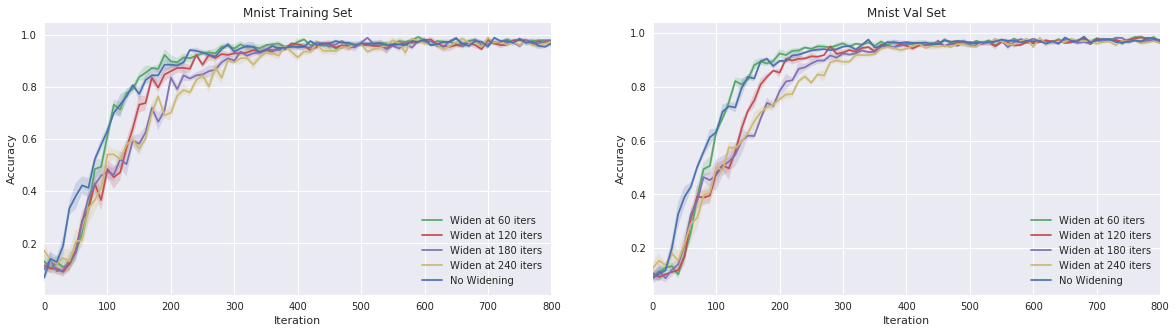

In [186]:
# Grab old results
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10
old_results = []
old_results_val = []
for i in range(len(our_init_results)):
    old_results.append(our_init_results[i][:81])
    old_results_val.append(our_init_results_val[i][:81])
    
# Plot results
plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=widen_results[60], time=xaxis, color=cp[1], condition="Widen at 60 iters")
sns.tsplot(data=widen_results[120], time=xaxis, color=cp[2], condition="Widen at 120 iters")
sns.tsplot(data=widen_results[180], time=xaxis, color=cp[3], condition="Widen at 180 iters")
sns.tsplot(data=widen_results[240], time=xaxis, color=cp[4], condition="Widen at 240 iters")
sns.tsplot(data=old_results, time=xaxis, color=cp[0], condition="No Widening")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=widen_results_val[60], time=xaxis, color=cp[1], condition="Widen at 60 iters")
sns.tsplot(data=widen_results_val[120], time=xaxis, color=cp[2], condition="Widen at 120 iters")
sns.tsplot(data=widen_results_val[180], time=xaxis, color=cp[3], condition="Widen at 180 iters")
sns.tsplot(data=widen_results_val[240], time=xaxis, color=cp[4], condition="Widen at 240 iters")
sns.tsplot(data=old_results_val, time=xaxis, color=cp[0], condition="No Widening")

### Initially implementing R2DeeperR, by (hacky) Mnist_Residual_Network_v3

We're going to alter the code from Mnist Residual Network v2. A hacky way to implement the deepen transform is to just keep all of the layers initialized at the start, and only use a subset of the layers before the "deepen" transform. Therefore, in this iteration, deepening the network will correspond to just setting a flag. (It will be more complex for the general Inception Resnet case, but not much, as it's still the same idea).

N.B. We changed this so that there's a noticable change in the number of parameters before and after the transform! But, it's the same either way that it's implemented. (Initializing it at the start is simpler, but, less demonstrative of the transform in the sanity check)

Because a 6 residual block (i.e. 18 layer) network is a little overkill for Mnist, we reduce it to just 2 residual blocks before the deepen, and 4 after.

In [ ]:
class Mnist_Resnet_v3(nn.Module):
    def __init__(self, identity_initialize=True, thin=False, deeper=False, noise_ratio=1.0e-8):
        # Superclass initializer
        super(Mnist_Resnet_v3, self).__init__()
        
        # Variables to be able to widen properly & consistently. Deepen now if deeper==True
        self.thin = thin
        self.identity_initialize = identity_initialize
        self.deeper = deeper
        if self.deeper:
            self.deepen()
        
        # Make the three conv layers, with three max pools        
        i, o = (1, 16) if not thin else (1, 8)
        self.resblock1 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]  
        
        i, o = (16, 32) if not thin else (8, 16)
        self.resblock2 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]  
        
#         i, o = (32, 64) if not thin else (16, 32)
#         self.resblock3 = R2R_residual_block_v2(input_channels=i, 
#                                                output_channels=o, 
#                                                identity_initialize=identity_initialize,
#                                                noise_ratio=noise_ratio) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.final_conv_channels = 64 if not thin else 32
        self.linear1 = nn.Linear(4*4*self.final_conv_channels, 256)
        self.linear2 = nn.Linear(256, 10)
        
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        if self.deeper:
            x = self.resblock3(x)
        else:
            # if ignoring 3rd block, then make it an identity (v. hacky here...)
            buf_shape = x.size()
            buf_shape = (buf_shape[0], buf_shape[1]*2, buf_shape[2], buf_shape[3])
            buf = t.zeros(buf_shape)
            buf[:,:x.size()[1]] = x
            x = buf
            
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*self.final_conv_channels))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x
    
    
    def widen(self):
        self.resblock1.widen(8)
        self.resblock2.widen(16)
        if self.deeper: 
            self.resblock3.widen(32)
        
        # so that deepen works correctly!
        self.thin = False
        
        
    def deepen(self):
        self.deeper = True
        
        i, o = (32, 64) if not self.thin else (16, 32)
        self.resblock3 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=self.identity_initialize,
                                               noise_ratio=self.noise_ratio) # [-1, 64, 8, 8]
 

### Sanity check, functions are identical before and after the deepen transform

Basically just a c&p from the check for the widen transform before. Note because of how we implemented the network, the number of parameters is the same before and after.

In [188]:
# Make a mnist resnet v3
model = Mnist_Resnet_v3(noise_ratio=0.0)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen and check that the outputs are (almost) identical
model.deepen()
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Params in model before widen: 294522
Params in model after widen: 391418


### Sanity check using number of floating point operations

Here we compute the number of floating point operations for the forward pass of Mnist Resnet v1, and v3 after deepening and widening. v3 should have less or equal to v1.

In [189]:
from flops_utils import *

xs, _ = DatasetCudaWrapper(MnistDataset(32)).next_batch()

model = Mnist_Resnet_v3(thin=True)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
thin_shallow_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=True)
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
wide_shallow_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=True)
model.deepen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
thin_deep_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=True)
model.deepen()
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
wide_deep_flops = model.compute_average_flops_cost()

baseline_model = Mnist_Resnet_v1()
baseline_model = add_flops_counting_methods(baseline_model)
baseline_model.start_flops_count()

_ = baseline_model(xs)
baseline_flops = model.compute_average_flops_cost()

print("v1 flops: %d" % baseline_flops)
print("v3 thin, shallow flops: %d" % thin_shallow_flops)
print("v3 thin, deeper flops: %d" % thin_deep_flops)
print("v3 wider, shallow flops: %d" % wide_shallow_flops)
print("v3 wider, deeper flops: %d" % wide_deep_flops)

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
v1 flops: 31852544
v3 thin, shallow flops: 5767168
v3 thin, deeper flops: 8855552
v3 wider, shallow flops: 20959232
v3 wider, deeper flops: 31852544


### Plotting the results (with respect to number of updates) of using R2DeeperR at different times

We run the eval loop on many networks, calling the deepen() transform at differing stages of training to see what effect it has.

Note that this is NOT representative of how long the models took to train. Updates on the smaller models are MUCH quicker. So it will look like the smaller networks did worst, but, they actually trained quicker, hitting the same performance.

In [190]:
# run our init, with widen at 60,120,180,240 iters
deepen_results = {}
deepen_results_val = {}
deepen_times = {}

dataset = DatasetCudaWrapper(MnistDataset(64))

for deepen in [60,120,180,240]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Mnist_Resnet_v3(thin=False)
        model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, deepen=deepen)
        elapsed_time = time.time() - start_time
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    deepen_results[deepen] = results
    deepen_results_val[deepen] = results_val
    deepen_times[deepen] = (np.mean(times), np.std(times))

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.125000, Current val: 0.156250.
(Iter 10). Current train: 0.265625, Current val: 0.109375.
(Iter 20). Current train: 0.046875, Current val: 0.101562.
(Iter 30). Current train: 0.078125, Current val: 0.085938.
(Iter 40). Current train: 0.281250, Current val: 0.242188.
(Iter 50). Current train: 0.343750, Current val: 0.265625.
(Iter 60). Current train: 0.140625, C

(Iter 460). Current train: 0.921875, Current val: 0.953125.
(Iter 470). Current train: 0.968750, Current val: 0.968750.
(Iter 480). Current train: 0.984375, Current val: 0.960938.
(Iter 490). Current train: 0.984375, Current val: 0.984375.
(Iter 500). Current train: 0.953125, Current val: 0.968750.
(Iter 510). Current train: 0.953125, Current val: 0.968750.
(Iter 520). Current train: 0.984375, Current val: 0.984375.
(Iter 530). Current train: 1.000000, Current val: 0.960938.
(Iter 540). Current train: 0.968750, Current val: 0.976562.
(Iter 550). Current train: 0.953125, Current val: 0.968750.
(Iter 560). Current train: 0.968750, Current val: 0.960938.
(Iter 570). Current train: 0.953125, Current val: 0.992188.
(Iter 580). Current train: 0.968750, Current val: 0.953125.
(Iter 590). Current train: 0.953125, Current val: 0.968750.
(Iter 600). Current train: 1.000000, Current val: 0.984375.
(Iter 610). Current train: 0.953125, Current val: 0.992188.
(Iter 620). Current train: 1.000000, Cur

(Iter 210). Current train: 0.906250, Current val: 0.921875.
(Iter 220). Current train: 0.984375, Current val: 0.960938.
(Iter 230). Current train: 0.921875, Current val: 0.890625.
(Iter 240). Current train: 0.937500, Current val: 0.929688.
(Iter 250). Current train: 0.968750, Current val: 0.968750.
(Iter 260). Current train: 1.000000, Current val: 0.953125.
(Iter 270). Current train: 0.968750, Current val: 0.968750.
(Iter 280). Current train: 0.921875, Current val: 0.960938.
(Iter 290). Current train: 0.859375, Current val: 0.937500.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.937500, Current val: 0.984375.
(Iter 320). Current train: 0.953125, Current val: 0.906250.
(Iter 330). Current train: 0.984375, Current val: 0.937500.
(Iter 340). Current train: 0.906250, Current val: 0.960938.
(Iter 350). Current train: 0.953125, Current val: 0.968750.
(Iter 360). Current train: 0.953125, Current val: 0.945312.
(Iter 370). Current train: 0.921875, Cur

(Iter 770). Current train: 0.968750, Current val: 0.984375.
(Iter 780). Current train: 0.968750, Current val: 0.960938.
(Iter 790). Current train: 0.953125, Current val: 0.968750.
(Iter 800). Current train: 1.000000, Current val: 0.976562.
(Iter 0). Current train: 0.046875, Current val: 0.031250.
(Iter 10). Current train: 0.046875, Current val: 0.085938.
(Iter 20). Current train: 0.125000, Current val: 0.101562.
(Iter 30). Current train: 0.156250, Current val: 0.195312.
(Iter 40). Current train: 0.156250, Current val: 0.195312.
(Iter 50). Current train: 0.234375, Current val: 0.156250.
(Iter 60). Current train: 0.218750, Current val: 0.218750.
(Iter 70). Current train: 0.140625, Current val: 0.289062.
(Iter 80). Current train: 0.515625, Current val: 0.484375.
(Iter 90). Current train: 0.609375, Current val: 0.515625.
(Iter 100). Current train: 0.500000, Current val: 0.406250.
(Iter 110). Current train: 0.593750, Current val: 0.710938.
(Iter 120). Current train: 0.593750, Current val: 0

(Iter 520). Current train: 0.968750, Current val: 0.976562.
(Iter 530). Current train: 0.937500, Current val: 0.976562.
(Iter 540). Current train: 0.984375, Current val: 0.984375.
(Iter 550). Current train: 1.000000, Current val: 0.968750.
(Iter 560). Current train: 1.000000, Current val: 0.976562.
(Iter 570). Current train: 1.000000, Current val: 0.984375.
(Iter 580). Current train: 0.984375, Current val: 0.953125.
(Iter 590). Current train: 0.968750, Current val: 0.968750.
(Iter 600). Current train: 0.984375, Current val: 0.968750.
(Iter 610). Current train: 0.968750, Current val: 0.953125.
(Iter 620). Current train: 0.953125, Current val: 0.992188.
(Iter 630). Current train: 0.984375, Current val: 0.968750.
(Iter 640). Current train: 0.968750, Current val: 0.976562.
(Iter 650). Current train: 0.984375, Current val: 0.976562.
(Iter 660). Current train: 1.000000, Current val: 0.992188.
(Iter 670). Current train: 0.968750, Current val: 0.968750.
(Iter 680). Current train: 1.000000, Cur

(Iter 270). Current train: 0.968750, Current val: 0.953125.
(Iter 280). Current train: 0.937500, Current val: 0.953125.
(Iter 290). Current train: 0.906250, Current val: 0.953125.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.953125, Current val: 0.960938.
(Iter 320). Current train: 0.953125, Current val: 0.937500.
(Iter 330). Current train: 0.937500, Current val: 0.960938.
(Iter 340). Current train: 0.984375, Current val: 0.945312.
(Iter 350). Current train: 0.921875, Current val: 0.945312.
(Iter 360). Current train: 0.953125, Current val: 0.945312.
(Iter 370). Current train: 0.968750, Current val: 0.929688.
(Iter 380). Current train: 0.984375, Current val: 0.976562.
(Iter 390). Current train: 0.937500, Current val: 0.984375.
(Iter 400). Current train: 1.000000, Current val: 0.937500.
(Iter 410). Current train: 0.921875, Current val: 0.937500.
(Iter 420). Current train: 0.953125, Current val: 0.953125.
(Iter 430). Current train: 0.984375, Cur

(Iter 20). Current train: 0.203125, Current val: 0.125000.
(Iter 30). Current train: 0.187500, Current val: 0.226562.
(Iter 40). Current train: 0.187500, Current val: 0.125000.
(Iter 50). Current train: 0.171875, Current val: 0.187500.
(Iter 60). Current train: 0.218750, Current val: 0.195312.
(Iter 70). Current train: 0.296875, Current val: 0.320312.
(Iter 80). Current train: 0.359375, Current val: 0.375000.
(Iter 90). Current train: 0.312500, Current val: 0.398438.
(Iter 100). Current train: 0.562500, Current val: 0.500000.
(Iter 110). Current train: 0.578125, Current val: 0.453125.
(Iter 120). Current train: 0.484375, Current val: 0.500000.
(Iter 130). Current train: 0.531250, Current val: 0.500000.
(Iter 140). Current train: 0.515625, Current val: 0.648438.
(Iter 150). Current train: 0.656250, Current val: 0.625000.
(Iter 160). Current train: 0.640625, Current val: 0.687500.
(Iter 170). Current train: 0.750000, Current val: 0.734375.
(Iter 180). Current train: 0.718750, Current val

(Iter 580). Current train: 1.000000, Current val: 0.960938.
(Iter 590). Current train: 0.984375, Current val: 0.984375.
(Iter 600). Current train: 0.968750, Current val: 0.984375.
(Iter 610). Current train: 0.968750, Current val: 0.953125.
(Iter 620). Current train: 0.968750, Current val: 0.992188.
(Iter 630). Current train: 0.953125, Current val: 0.968750.
(Iter 640). Current train: 0.984375, Current val: 0.992188.
(Iter 650). Current train: 0.984375, Current val: 0.992188.
(Iter 660). Current train: 0.968750, Current val: 0.992188.
(Iter 670). Current train: 0.968750, Current val: 0.992188.
(Iter 680). Current train: 0.984375, Current val: 0.976562.
(Iter 690). Current train: 0.984375, Current val: 0.968750.
(Iter 700). Current train: 0.953125, Current val: 0.984375.
(Iter 710). Current train: 0.968750, Current val: 0.976562.
(Iter 720). Current train: 0.984375, Current val: 0.953125.
(Iter 730). Current train: 0.984375, Current val: 0.968750.
(Iter 740). Current train: 1.000000, Cur

(Iter 330). Current train: 0.984375, Current val: 0.953125.
(Iter 340). Current train: 0.968750, Current val: 0.914062.
(Iter 350). Current train: 0.890625, Current val: 0.937500.
(Iter 360). Current train: 0.968750, Current val: 0.921875.
(Iter 370). Current train: 0.937500, Current val: 0.937500.
(Iter 380). Current train: 0.906250, Current val: 0.914062.
(Iter 390). Current train: 0.921875, Current val: 0.937500.
(Iter 400). Current train: 0.890625, Current val: 0.921875.
(Iter 410). Current train: 0.890625, Current val: 0.976562.
(Iter 420). Current train: 0.968750, Current val: 0.968750.
(Iter 430). Current train: 0.953125, Current val: 0.976562.
(Iter 440). Current train: 0.968750, Current val: 0.968750.
(Iter 450). Current train: 0.921875, Current val: 0.921875.
(Iter 460). Current train: 0.968750, Current val: 0.945312.
(Iter 470). Current train: 0.937500, Current val: 0.953125.
(Iter 480). Current train: 0.968750, Current val: 0.968750.
(Iter 490). Current train: 0.937500, Cur

(Iter 80). Current train: 0.437500, Current val: 0.468750.
(Iter 90). Current train: 0.562500, Current val: 0.515625.
(Iter 100). Current train: 0.703125, Current val: 0.609375.
(Iter 110). Current train: 0.593750, Current val: 0.625000.
(Iter 120). Current train: 0.609375, Current val: 0.531250.
(Iter 130). Current train: 0.484375, Current val: 0.625000.
(Iter 140). Current train: 0.687500, Current val: 0.632812.
(Iter 150). Current train: 0.640625, Current val: 0.679688.
(Iter 160). Current train: 0.734375, Current val: 0.679688.
(Iter 170). Current train: 0.750000, Current val: 0.789062.
(Iter 180). Current train: 0.765625, Current val: 0.765625.
(Iter 190). Current train: 0.828125, Current val: 0.796875.
(Iter 200). Current train: 0.859375, Current val: 0.843750.
(Iter 210). Current train: 0.875000, Current val: 0.812500.
(Iter 220). Current train: 0.828125, Current val: 0.851562.
(Iter 230). Current train: 0.859375, Current val: 0.906250.
(Iter 240). Current train: 0.843750, Curre

(Iter 640). Current train: 0.968750, Current val: 0.929688.
(Iter 650). Current train: 0.937500, Current val: 0.968750.
(Iter 660). Current train: 0.984375, Current val: 0.992188.
(Iter 670). Current train: 0.984375, Current val: 0.984375.
(Iter 680). Current train: 0.953125, Current val: 0.992188.
(Iter 690). Current train: 1.000000, Current val: 0.937500.
(Iter 700). Current train: 0.937500, Current val: 0.984375.
(Iter 710). Current train: 0.984375, Current val: 1.000000.
(Iter 720). Current train: 1.000000, Current val: 0.976562.
(Iter 730). Current train: 0.937500, Current val: 0.976562.
(Iter 740). Current train: 0.968750, Current val: 0.976562.
(Iter 750). Current train: 0.968750, Current val: 0.960938.
(Iter 760). Current train: 0.984375, Current val: 0.968750.
(Iter 770). Current train: 0.968750, Current val: 0.968750.
(Iter 780). Current train: 0.921875, Current val: 0.968750.
(Iter 790). Current train: 0.984375, Current val: 0.984375.
(Iter 800). Current train: 0.968750, Cur

(Iter 390). Current train: 0.937500, Current val: 0.968750.
(Iter 400). Current train: 0.906250, Current val: 0.914062.
(Iter 410). Current train: 0.921875, Current val: 0.953125.
(Iter 420). Current train: 0.937500, Current val: 0.937500.
(Iter 430). Current train: 0.906250, Current val: 0.921875.
(Iter 440). Current train: 0.953125, Current val: 0.953125.
(Iter 450). Current train: 0.953125, Current val: 0.976562.
(Iter 460). Current train: 0.984375, Current val: 0.937500.
(Iter 470). Current train: 0.937500, Current val: 0.968750.
(Iter 480). Current train: 0.984375, Current val: 0.945312.
(Iter 490). Current train: 0.953125, Current val: 0.914062.
(Iter 500). Current train: 0.906250, Current val: 0.976562.
(Iter 510). Current train: 0.984375, Current val: 0.968750.
(Iter 520). Current train: 0.937500, Current val: 0.953125.
(Iter 530). Current train: 0.953125, Current val: 0.953125.
(Iter 540). Current train: 0.984375, Current val: 0.968750.
(Iter 550). Current train: 0.953125, Cur

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


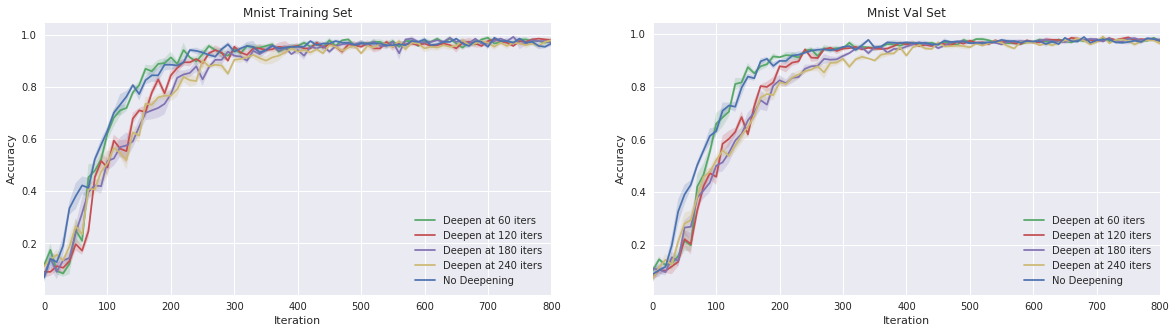

In [191]:
# Plot results
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=xaxis, color=cp[1], condition="Deepen at 60 iters")
sns.tsplot(data=deepen_results[120], time=xaxis, color=cp[2], condition="Deepen at 120 iters")
sns.tsplot(data=deepen_results[180], time=xaxis, color=cp[3], condition="Deepen at 180 iters")
sns.tsplot(data=deepen_results[240], time=xaxis, color=cp[4], condition="Deepen at 240 iters")
sns.tsplot(data=old_results, time=xaxis, color=cp[0], condition="No Deepening")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=deepen_results_val[60], time=xaxis, color=cp[1], condition="Deepen at 60 iters")
sns.tsplot(data=deepen_results_val[120], time=xaxis, color=cp[2], condition="Deepen at 120 iters")
sns.tsplot(data=deepen_results_val[180], time=xaxis, color=cp[3], condition="Deepen at 180 iters")
sns.tsplot(data=deepen_results_val[240], time=xaxis, color=cp[4], condition="Deepen at 240 iters")
sns.tsplot(data=old_results_val, time=xaxis, color=cp[0], condition="No Deepening")

### The more interesting results. Training with respect to the number of FLOPs.

We now compute the number of FLOPs used to reach each training point, and scale the x axis appropriately. This is more representative of what the time taken to train these models.

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz


/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


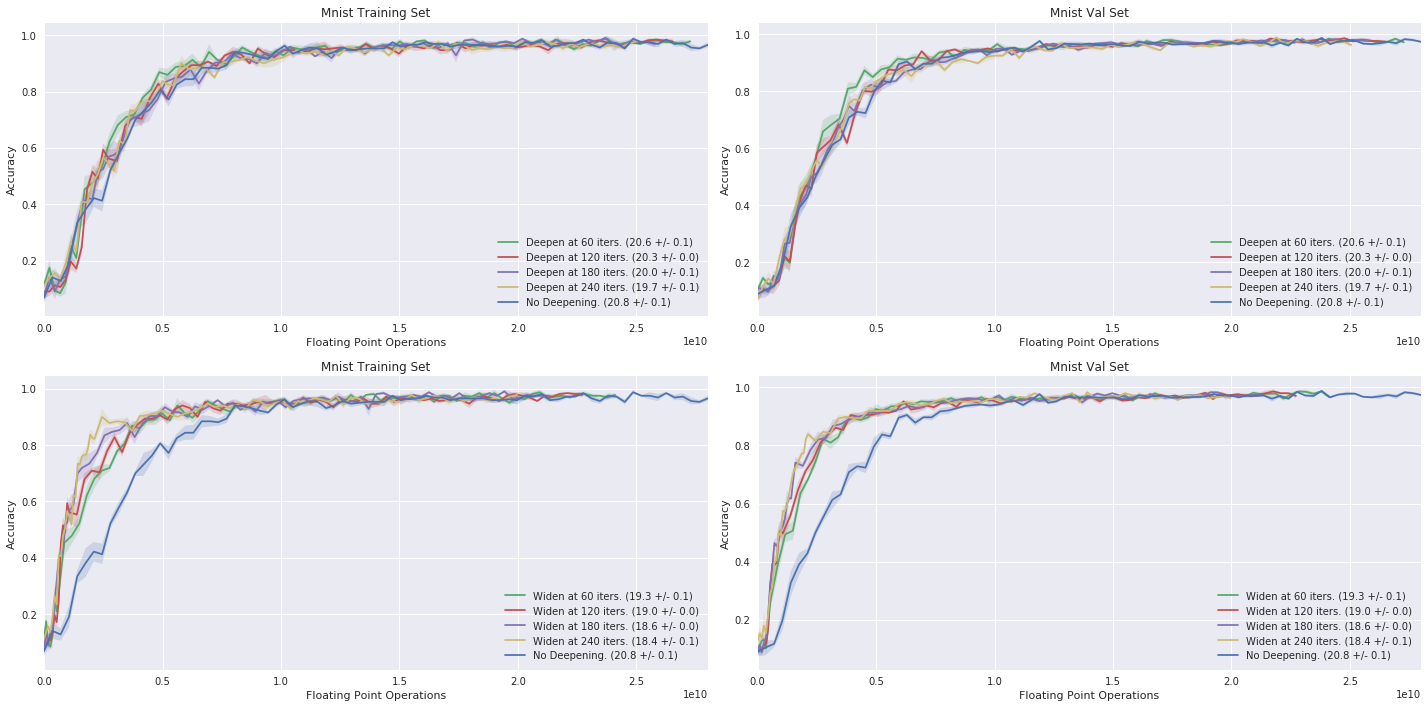

In [198]:
from flops_utils import *

dataset = DatasetCudaWrapper(MnistDataset(64))
xs, _ = dataset.next_batch(64)

model = Mnist_Resnet_v3(thin=False)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
pre_deepen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=False)
model.deepen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
post_deepen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v2(thin=True)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
pre_widen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v2(thin=True)
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
post_widen_flops = model.compute_average_flops_cost()

baseline_model = Mnist_Resnet_v1()
baseline_model = add_flops_counting_methods(baseline_model)
baseline_model.start_flops_count()

_ = baseline_model(xs)
baseline_flops = baseline_model.compute_average_flops_cost()


expansion_times_div_ten = [6,12,18,24]
train_iters_div_ten = 80

baseline_flopss = [i*10*baseline_flops for i in range(train_iters_div_ten+1)]
widen_flops = {}
for widen_div_ten in expansion_times_div_ten:
    flops_one = [i*10*pre_widen_flops for i in range(widen_div_ten+1)] 
    flops_two = [flops_one[-1] + i*10*post_widen_flops for i in range(1,train_iters_div_ten+1-widen_div_ten)]
    widen_flops[widen_div_ten*10] = flops_one + flops_two
deepen_flops = {}
for deepen_div_ten in expansion_times_div_ten:
    flops_one = [i*10*pre_deepen_flops for i in range(deepen_div_ten+1)] 
    flops_two = [flops_one[-1] + i*10*post_deepen_flops for i in range(1,train_iters_div_ten+1-deepen_div_ten)]
    deepen_flops[deepen_div_ten*10] = flops_one + flops_two
    

old_results_label = "No Deepening. (%.1f +/- %.1f)" % (our_init_mean_time, our_init_stddev_time)
widen_labels = []
for i_div_ten in expansion_times_div_ten:
    i = 10 * i_div_ten
    widen_labels.append("Widen at %d iters. (%.1f +/- %.1f)" % (i, widen_times[i][0], widen_times[i][1]))
deepen_labels = []
for i_div_ten in expansion_times_div_ten:
    i = 10 * i_div_ten
    deepen_labels.append("Deepen at %d iters. (%.1f +/- %.1f)" % (i, deepen_times[i][0], deepen_times[i][1]))
    

# Plot results
plt.figure(figsize=(20,10))
#plt.tight_layout()

plt.subplot(221)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=deepen_flops[60], color=cp[1], condition=deepen_labels[0])
sns.tsplot(data=deepen_results[120], time=deepen_flops[120], color=cp[2], condition=deepen_labels[1])
sns.tsplot(data=deepen_results[180], time=deepen_flops[180], color=cp[3], condition=deepen_labels[2])
sns.tsplot(data=deepen_results[240], time=deepen_flops[240], color=cp[4], condition=deepen_labels[3])
sns.tsplot(data=old_results, time=baseline_flopss, color=cp[0], condition=old_results_label)
plt.legend()

plt.subplot(222)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=deepen_results_val[60], time=deepen_flops[60], color=cp[1], condition=deepen_labels[0])
sns.tsplot(data=deepen_results_val[120], time=deepen_flops[120], color=cp[2], condition=deepen_labels[1])
sns.tsplot(data=deepen_results_val[180], time=deepen_flops[180], color=cp[3], condition=deepen_labels[2])
sns.tsplot(data=deepen_results_val[240], time=deepen_flops[240], color=cp[4], condition=deepen_labels[3])
sns.tsplot(data=old_results_val, time=baseline_flopss, color=cp[0], condition=old_results_label)


plt.tight_layout()
plt.subplot(223)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=widen_flops[60], color=cp[1], condition=widen_labels[0])
sns.tsplot(data=deepen_results[120], time=widen_flops[120], color=cp[2], condition=widen_labels[1])
sns.tsplot(data=deepen_results[180], time=widen_flops[180], color=cp[3], condition=widen_labels[2])
sns.tsplot(data=deepen_results[240], time=widen_flops[240], color=cp[4], condition=widen_labels[3])
sns.tsplot(data=old_results, time=baseline_flopss, color=cp[0], condition=old_results_label)
plt.legend()

plt.subplot(224)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=widen_results_val[60], time=widen_flops[60], color=cp[1], condition=widen_labels[0])
sns.tsplot(data=widen_results_val[120], time=widen_flops[120], color=cp[2], condition=widen_labels[1])
sns.tsplot(data=widen_results_val[180], time=widen_flops[180], color=cp[3], condition=widen_labels[2])
sns.tsplot(data=widen_results_val[240], time=widen_flops[240], color=cp[4], condition=widen_labels[3]) 
sns.tsplot(data=old_results_val, time=baseline_flopss, color=cp[0], condition=old_results_label)

plt.tight_layout()

# IMPORTANT TODO: MAKE THE BELOW CONSISTENT WITH BATCH_CIFAR_TESTS.PY

## Testing on CIFAR-10

### Re-implement our resnet appropriately for CIFAR-10

We implement cifar_resnet_v1, and then run all the same tests as we did on mnist, this is a much greater stress test. We added into the widen and deepen functions to add param groups into the optimizers. (Before adding this results were poor, as initializing a new optimizer from scratch lead to poor performance (lost all of the stats from training so far)).

In [380]:
def ema(list, e=0.9):
    ema = [list[0]]
    for i in list[1:]:
        ema.append(e * i + (1-e) * ema[-1])
    return ema

def ema_dl(double_list, e=0.9):
    dl = []
    for l in double_list:
        dl.append(ema(l, e))
    return dl
    

In [ ]:
class Cifar_Resnet_v1(nn.Module):
    def __init__(self, identity_initialize=True, thin=False, deeper=True, noise_ratio=1.0e-6):
        # Superclass initializer
        super(Cifar_Resnet_v1, self).__init__()
        
        # Channel sizes to use across layers (widen will increase this if necessary)
        self.channel_sizes = [3, 32, 64, 128]
        
        # Make the three conv layers, with three max pools        
        self.resblock1 = R2R_residual_block_v2(input_channels=self.channel_sizes[0], 
                                               output_channels=self.channel_sizes[1], 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 32, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 16, 16]  
        self.resblock2 = R2R_residual_block_v2(input_channels=self.channel_sizes[1], 
                                               output_channels=self.channel_sizes[2], 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 8, 8]  
#         self.resblock3 = R2R_residual_block_v2(input_channels=self.channel_sizes[2], 
#                                                output_channels=self.channel_sizes[3], 
#                                                identity_initialize=identity_initialize,
#                                                noise_ratio=noise_ratio) # [-1, 64, 8, 8]
        self.resblock3 = None
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 128, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(4*4*self.channel_sizes[3], 1024)
        self.linear2 = nn.Linear(1024, 10)
        
        # Variables to be able to widen properly & consistently. Deepen now if deeper==True
        self.identity_initialize = identity_initialize
        self.deeper = deeper
        if self.deeper:
            self.deepen(None)
        
        # if we're initializing as wide, widen it now, after the resblocks have been defined
        self.thin = thin
        if not thin:
            self.widen(None)
        
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        if self.deeper:
            x = self.resblock3(x)
        else:
            # if ignoring 3rd block, then make it an identity (v. hacky here...)
            buf = t.zeros((x.size()[0], self.channel_sizes[3], 8, 8))
            buf[:,:x.size()[1]] = x
            x = buf
            
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*self.channel_sizes[3]))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x
    
    
    def widen(self, optimizer):
        self.thin = False
        
        self.resblock1.widen(self.channel_sizes[1])
        self.resblock2.widen(self.channel_sizes[2])
        if self.deeper: 
            self.resblock3.widen(self.channel_sizes[3])
        
        new_modules = [self.resblock1, self.resblock2]
        if self.deeper:
            new_modules.append(self.resblock3)
        self._add_modules_to_optimizer(new_modules, optimizer)
        
        
    def deepen(self, optimizer):
        self.deeper = True
        
        self.resblock3 = R2R_residual_block_v2(input_channels=self.channel_sizes[2], 
                                               output_channels=self.channel_sizes[3], 
                                               identity_initialize=self.identity_initialize,
                                               noise_ratio=self.noise_ratio) # [-1, 64, 8, 8]
        
        if optimizer is not None:
            new_modules = [self.resblock3]
            self._add_modules_to_optimizer(new_modules, optimizer)
    
    
    
    def _add_modules_to_optimizer(self, modules, optimizer):
        """
        Optimizer is a non optional parameter, but we pass none in from the initializer. It should never 
        be None if we are calling widen/deepen from outside of the module. We allow it to be None for when 
        its called (from the initializer) before an Optimizer is created.
        """
        if optimizer is not None:
            for module in modules:
                for param_group in module.parameters():
                    optimizer.add_param_group({'params': param_group})

In [447]:
# Evaluate a model
def count_gen(generator):
    i = 0
    for _ in generator:
        i += 1
    return i

def evaluate(model, dataset, widen=-1, deepen=-1):
    # Setup bookeeping and optimizer
    train_iters = 5000
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
    
    # train for 300 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the R2R transform
        if i ==  widen:
            model.widen(optimizer)
        if i == deepen: 
            model.deepen(optimizer)
            
        if i == 1500:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 6e-4
        elif i == 3000:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 3e-4
        elif i == 4500:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
        
        # compute loss
        xs, ys = dataset.next_batch(32)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(64)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [448]:
# # Cifar dataset
# from dataset import CifarDataset

# dataset = DatasetCudaWrapper(CifarDataset(64))

# # run our initialization 5 times
# our_init_results = []
# our_init_results_val = []
# times = []
# for i in range(5):
#     model = Cifar_Resnet_v1(identity_initialize=True, thin=False, deeper=True)
#     model = model.cuda()
#     start_time = time.time()
#     train_acc, val_acc = evaluate(model, dataset)
#     elapsed_time = time.time() - start_time
#     del model
    
#     our_init_results.append(train_acc)
#     our_init_results_val.append(val_acc)
#     times.append(elapsed_time)

# our_init_mean_time = np.mean(times)
# our_init_stddev_time = np.std(times)
    
# # run he initialization 5 times
# he_init_results = []
# he_init_results_val = []
# for i in range(5):
#     model = Cifar_Resnet_v1(identity_initialize=False, thin=False, deeper=True)
#     model = model.cuda()
#     train_acc, val_acc = evaluate(model, dataset)
#     del model
#     he_init_results.append(train_acc)
#     he_init_results_val.append(val_acc)

In [449]:
# # Plot the results of the above tests with confidence intervals
# plt.figure(figsize=(20,5))
# plt.tight_layout()

# our_init_ema = ema_dl(our_init_results, e=0.2)
# he_init_ema = ema_dl(he_init_results, e=0.2)
# our_init_ema_val = ema_dl(our_init_results, e=0.2)
# he_init_ema_val = ema_dl(he_init_results, e=0.2)

# xaxis = np.array(range(501)) * 10

# plt.subplot(121)
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Mnist Training Set')
# sns.tsplot(data=our_init_ema, time=xaxis, condition="Our Init")
# sns.tsplot(data=he_init_ema, time=xaxis, color="g", condition="He Init")
# plt.legend()

# plt.subplot(122)
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Mnist Val Set')
# sns.tsplot(data=our_init_ema_val, time=xaxis, condition="Our Init")
# sns.tsplot(data=he_init_ema_val, time=xaxis, color="g", condition="He Init")

In [450]:
# run our init, with widen at 500, 1000, 2000 iters
widen_results = {}
widen_results_val = {}
widen_times = {}

dataset = DatasetCudaWrapper(CifarDataset(64))

for widen in [50,1000,2000]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Cifar_Resnet_v1(thin=True, noise_ratio=0.0)
        model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, widen=widen)
        elapsed_time = time.time() - start_time
        del model
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    widen_results[widen] = results
    widen_results_val[widen]= results_val
    widen_times[widen] = (np.mean(times), np.std(times))

(Iter 0). Current train: 0.062500, Current val: 0.234375.
(Iter 10). Current train: 0.250000, Current val: 0.296875.
(Iter 20). Current train: 0.156250, Current val: 0.187500.
(Iter 30). Current train: 0.250000, Current val: 0.343750.
(Iter 40). Current train: 0.156250, Current val: 0.171875.
torch.Size([64, 64, 3, 3])
tensor(1.00000e-03 *
       [[ 1.9714, -1.8911, -1.9456],
        [-1.5915, -1.9873, -1.9892],
        [-1.9893, -1.9926, -1.9914]])
tensor(1.00000e-03 *
       [[ 1.9823,  1.9713,  1.9217],
        [ 1.9777,  1.9533, -1.5092],
        [ 1.9728,  1.8514,  1.7681]])
(Iter 50). Current train: 0.406250, Current val: 0.171875.
torch.Size([64, 64, 3, 3])
tensor(1.00000e-02 *
       [[ 1.0894,  0.2987,  0.0569],
        [ 0.2857, -0.6535, -0.4947],
        [-0.5124, -0.9917, -0.4863]])
tensor(1.00000e-02 *
       [[ 1.4028,  1.5080,  1.4486],
        [ 1.4216,  1.3812,  0.9681],
        [ 1.4918,  1.2861,  1.2758]])
(Iter 60). Current train: 0.343750, Current val: 0.218750.
to

torch.Size([64, 64, 3, 3])
tensor([[ 0.0920,  0.0552,  0.0173],
        [ 0.1038,  0.0769,  0.0413],
        [ 0.0677,  0.0639,  0.0504]])
tensor(1.00000e-02 *
       [[ 7.5474,  7.7425,  5.6713],
        [ 5.4956,  6.7896,  4.9952],
        [ 4.3527,  5.9875,  5.6923]])
(Iter 280). Current train: 0.687500, Current val: 0.390625.
torch.Size([64, 64, 3, 3])
tensor([[ 0.0961,  0.0585,  0.0193],
        [ 0.1078,  0.0788,  0.0421],
        [ 0.0682,  0.0635,  0.0482]])
tensor(1.00000e-02 *
       [[ 7.6642,  7.7635,  5.5604],
        [ 5.5285,  6.7529,  4.9834],
        [ 4.0006,  5.9326,  5.6649]])
(Iter 290). Current train: 0.500000, Current val: 0.437500.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1003,  0.0608,  0.0189],
        [ 0.1081,  0.0785,  0.0402],
        [ 0.0662,  0.0626,  0.0453]])
tensor(1.00000e-02 *
       [[ 7.6468,  7.6277,  5.2684],
        [ 5.3288,  6.6120,  4.8073],
        [ 3.6133,  5.8758,  5.6019]])
(Iter 300). Current train: 0.468750, Current val: 0.328125.
torc

torch.Size([64, 64, 3, 3])
tensor([[ 0.1386,  0.0801,  0.0069],
        [ 0.1629,  0.1419,  0.0607],
        [ 0.0992,  0.1256,  0.0865]])
tensor(1.00000e-02 *
       [[ 8.9441,  8.9229,  5.0593],
        [ 2.6668,  5.9866,  5.4398],
        [-0.6222,  2.9665,  4.9824]])
(Iter 530). Current train: 0.687500, Current val: 0.562500.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1464,  0.0849,  0.0122],
        [ 0.1686,  0.1492,  0.0655],
        [ 0.1026,  0.1289,  0.0939]])
tensor(1.00000e-02 *
       [[ 8.8846,  8.7412,  4.9677],
        [ 2.2810,  5.9876,  5.3141],
        [-1.1319,  3.1207,  5.2230]])
(Iter 540). Current train: 0.468750, Current val: 0.640625.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1536,  0.0881,  0.0081],
        [ 0.1724,  0.1565,  0.0643],
        [ 0.0990,  0.1294,  0.0948]])
tensor(1.00000e-02 *
       [[ 9.2378,  9.1352,  5.0317],
        [ 1.9408,  6.2684,  5.0414],
        [-2.0186,  3.5012,  5.6955]])
(Iter 550). Current train: 0.531250, Current val: 0.546875.
torc

torch.Size([64, 64, 3, 3])
tensor([[ 0.1473,  0.0750, -0.0378],
        [ 0.1665,  0.1719,  0.0535],
        [ 0.0612,  0.1109,  0.0699]])
tensor(1.00000e-02 *
       [[ 9.3563,  2.6524, -0.7045],
        [-1.3525,  1.5798, -4.2585],
        [-9.5067, -3.0556,  2.3020]])
(Iter 790). Current train: 0.718750, Current val: 0.671875.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1482,  0.0729, -0.0393],
        [ 0.1657,  0.1712,  0.0534],
        [ 0.0600,  0.1098,  0.0718]])
tensor(1.00000e-02 *
       [[ 9.0766,  2.9931, -0.1692],
        [-1.9509,  1.3950, -4.2168],
        [-9.3362, -2.9883,  1.8704]])
(Iter 800). Current train: 0.593750, Current val: 0.671875.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1427,  0.0674, -0.0407],
        [ 0.1614,  0.1687,  0.0521],
        [ 0.0561,  0.1091,  0.0723]])
tensor(1.00000e-02 *
       [[ 8.6915,  2.9289,  0.0334],
        [-2.4673,  1.0320, -4.1651],
        [-8.6378, -2.4118,  2.3652]])
(Iter 810). Current train: 0.500000, Current val: 0.625000.
torc

torch.Size([64, 64, 3, 3])
tensor([[ 0.1410,  0.0785, -0.0532],
        [ 0.1751,  0.1832,  0.0832],
        [ 0.0816,  0.1376,  0.0821]])
tensor([[ 0.1045, -0.0010, -0.0039],
        [-0.0291,  0.0273, -0.0471],
        [-0.1145, -0.0304,  0.0400]])
(Iter 1050). Current train: 0.718750, Current val: 0.640625.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1457,  0.0804, -0.0518],
        [ 0.1803,  0.1853,  0.0823],
        [ 0.0856,  0.1379,  0.0799]])
tensor([[ 0.1092, -0.0002, -0.0033],
        [-0.0311,  0.0287, -0.0466],
        [-0.1188, -0.0323,  0.0426]])
(Iter 1060). Current train: 0.687500, Current val: 0.671875.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1483,  0.0797, -0.0498],
        [ 0.1834,  0.1868,  0.0832],
        [ 0.0920,  0.1424,  0.0801]])
tensor([[ 0.1096, -0.0010, -0.0061],
        [-0.0370,  0.0259, -0.0545],
        [-0.1187, -0.0341,  0.0403]])
(Iter 1070). Current train: 0.687500, Current val: 0.640625.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1439,  0.0729, -0.0553],


torch.Size([64, 64, 3, 3])
tensor([[ 0.1512,  0.0955, -0.0440],
        [ 0.1964,  0.2186,  0.1225],
        [ 0.0941,  0.1380,  0.0671]])
tensor([[ 0.1110, -0.0058, -0.0087],
        [-0.0692,  0.0092, -0.0889],
        [-0.1625, -0.0578,  0.0146]])
(Iter 1320). Current train: 0.687500, Current val: 0.656250.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1471,  0.0935, -0.0469],
        [ 0.1956,  0.2193,  0.1169],
        [ 0.0898,  0.1368,  0.0619]])
tensor([[ 0.1091, -0.0087, -0.0131],
        [-0.0714,  0.0069, -0.0942],
        [-0.1615, -0.0564,  0.0131]])
(Iter 1330). Current train: 0.562500, Current val: 0.687500.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1479,  0.0921, -0.0518],
        [ 0.1964,  0.2230,  0.1160],
        [ 0.0870,  0.1425,  0.0641]])
tensor([[ 0.1120, -0.0076, -0.0189],
        [-0.0700,  0.0091, -0.0967],
        [-0.1596, -0.0528,  0.0146]])
(Iter 1340). Current train: 0.781250, Current val: 0.703125.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1502,  0.0942, -0.0522],


torch.Size([64, 64, 3, 3])
tensor([[ 0.1487,  0.0929, -0.0606],
        [ 0.2459,  0.2656,  0.1301],
        [ 0.1039,  0.1471,  0.0675]])
tensor([[ 0.1146, -0.0266, -0.0180],
        [-0.0860,  0.0016, -0.0916],
        [-0.1674, -0.0820, -0.0040]])
(Iter 1590). Current train: 0.843750, Current val: 0.656250.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1490,  0.0939, -0.0615],
        [ 0.2459,  0.2653,  0.1310],
        [ 0.1026,  0.1463,  0.0661]])
tensor([[ 0.1160, -0.0254, -0.0151],
        [-0.0865,  0.0016, -0.0888],
        [-0.1683, -0.0842, -0.0036]])
(Iter 1600). Current train: 0.625000, Current val: 0.718750.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1475,  0.0929, -0.0613],
        [ 0.2437,  0.2625,  0.1302],
        [ 0.1017,  0.1463,  0.0656]])
tensor([[ 0.1168, -0.0251, -0.0125],
        [-0.0847,  0.0021, -0.0854],
        [-0.1684, -0.0855, -0.0029]])
(Iter 1610). Current train: 0.812500, Current val: 0.656250.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1472,  0.0918, -0.0595],


torch.Size([64, 64, 3, 3])
tensor([[ 0.1552,  0.0997, -0.0592],
        [ 0.2546,  0.2654,  0.1329],
        [ 0.1084,  0.1448,  0.0716]])
tensor([[ 0.1252, -0.0081,  0.0024],
        [-0.0981, -0.0079, -0.0840],
        [-0.1699, -0.1151, -0.0283]])
(Iter 1860). Current train: 0.625000, Current val: 0.718750.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1545,  0.0984, -0.0619],
        [ 0.2558,  0.2664,  0.1327],
        [ 0.1087,  0.1470,  0.0722]])
tensor([[ 0.1249, -0.0087, -0.0001],
        [-0.0991, -0.0080, -0.0858],
        [-0.1724, -0.1150, -0.0290]])
(Iter 1870). Current train: 0.718750, Current val: 0.656250.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1543,  0.0960, -0.0637],
        [ 0.2564,  0.2672,  0.1313],
        [ 0.1071,  0.1481,  0.0711]])
tensor([[ 0.1264, -0.0044,  0.0013],
        [-0.1006, -0.0066, -0.0858],
        [-0.1767, -0.1141, -0.0299]])
(Iter 1880). Current train: 0.718750, Current val: 0.859375.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1499,  0.0892, -0.0683],


torch.Size([64, 64, 3, 3])
tensor([[ 0.1398,  0.0770, -0.0668],
        [ 0.2593,  0.2561,  0.1386],
        [ 0.1044,  0.1472,  0.0676]])
tensor([[ 0.1347,  0.0133,  0.0043],
        [-0.0903,  0.0014, -0.0716],
        [-0.1719, -0.1147, -0.0274]])
(Iter 2130). Current train: 0.781250, Current val: 0.796875.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1358,  0.0727, -0.0713],
        [ 0.2563,  0.2533,  0.1361],
        [ 0.1039,  0.1460,  0.0670]])
tensor([[ 1.3319e-01,  1.1276e-02, -8.4609e-05],
        [-9.1046e-02, -3.7635e-06, -7.3838e-02],
        [-1.7170e-01, -1.1596e-01, -2.9740e-02]])
(Iter 2140). Current train: 0.687500, Current val: 0.734375.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1341,  0.0711, -0.0725],
        [ 0.2538,  0.2503,  0.1319],
        [ 0.1065,  0.1482,  0.0676]])
tensor([[ 0.1319,  0.0098, -0.0005],
        [-0.0911, -0.0015, -0.0741],
        [-0.1708, -0.1165, -0.0310]])
(Iter 2150). Current train: 0.718750, Current val: 0.718750.
torch.Size([64, 64, 3, 3])
t

torch.Size([64, 64, 3, 3])
tensor([[ 0.1195,  0.0584, -0.0816],
        [ 0.2573,  0.2448,  0.1355],
        [ 0.1053,  0.1508,  0.0503]])
tensor([[ 0.1454,  0.0293,  0.0310],
        [-0.1064, -0.0001, -0.0668],
        [-0.1826, -0.1238, -0.0310]])
(Iter 2400). Current train: 0.875000, Current val: 0.734375.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1198,  0.0596, -0.0809],
        [ 0.2591,  0.2488,  0.1359],
        [ 0.1057,  0.1538,  0.0497]])
tensor([[ 0.1464,  0.0317,  0.0335],
        [-0.1052,  0.0026, -0.0633],
        [-0.1796, -0.1209, -0.0269]])
(Iter 2410). Current train: 0.781250, Current val: 0.765625.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1204,  0.0592, -0.0818],
        [ 0.2601,  0.2501,  0.1352],
        [ 0.1057,  0.1551,  0.0496]])
tensor([[ 0.1453,  0.0310,  0.0337],
        [-0.1049,  0.0029, -0.0625],
        [-0.1758, -0.1188, -0.0224]])
(Iter 2420). Current train: 0.687500, Current val: 0.812500.
torch.Size([64, 64, 3, 3])
tensor([[ 0.1191,  0.0571, -0.0817],


KeyboardInterrupt: 

In [413]:
# # Grab old results
# plt.figure(figsize=(10,11))
# plt.tight_layout()

# xaxis = np.array(range(501)) * 10
# old_results = []
# old_results_val = []
# for i in range(len(our_init_results)):
#     old_results.append(our_init_results[i])
#     old_results_val.append(our_init_results_val[i])

# old_results_ema = ema_dl(old_results, e=0.1)
# old_results_ema_val = ema_dl(old_results, e=0.1)
# widen_ema = {}
# for key in widen_results:
#     widen_ema[key] = ema_dl(widen_results[key], e=0.1)
# widen_ema_val = {}
# for key in widen_results_val:
#     widen_ema_val[key] = ema_dl(widen_results_val[key], e=0.1)

    
# # Plot results
# plt.subplot(2,1,1)
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Cifar Training Set')
# cp = sns.color_palette("deep", 10)
# sns.tsplot(data=widen_ema[500], time=xaxis, color=cp[1], condition="Widen at 500 iters")
# sns.tsplot(data=widen_ema[1000], time=xaxis, color=cp[2], condition="Widen at 1000 iters")
# sns.tsplot(data=widen_ema[2000], time=xaxis, color=cp[3], condition="Widen at 2000 iters")
# sns.tsplot(data=old_results_ema, time=xaxis, color=cp[0], condition="No Widening")
# plt.legend()

# plt.subplot(2,1,2)
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Cifar Val Set')
# sns.tsplot(data=widen_ema_val[500], time=xaxis, color=cp[1], condition="Widen at 500 iters")
# sns.tsplot(data=widen_ema_val[1000], time=xaxis, color=cp[2], condition="Widen at 1000 iters")
# sns.tsplot(data=widen_ema_val[2000], time=xaxis, color=cp[3], condition="Widen at 2000 iters")
# sns.tsplot(data=old_results_ema_val, time=xaxis, color=cp[0], condition="No Widening")


# plt.tight_layout()

In [414]:
# # run our init, with widen at 500,1000,2000 iters
# deepen_results = {}
# deepen_results_val = {}
# deepen_times = {}

# dataset = DatasetCudaWrapper(CifarDataset(64))

# for deepen in [50,1000,2000]:
#     results = []
#     results_val = []
#     times = []
    
#     for i in range(5):
#         model = Cifar_Resnet_v1(deeper=False)
#         model = model.cuda()
#         start_time = time.time()
#         train_acc, val_acc = evaluate(model, dataset, deepen=deepen)
#         elapsed_time = time.time() - start_time
#         del model
        
#         results.append(train_acc)
#         results_val.append(val_acc)
#         times.append(elapsed_time)
        
#     deepen_results[deepen] = results
#     deepen_results_val[deepen] = results_val
#     deepen_times[deepen] = (np.mean(times), np.std(times))

(Iter 0). Current train: 0.093750, Current val: 0.078125.
(Iter 10). Current train: 0.125000, Current val: 0.218750.
(Iter 20). Current train: 0.312500, Current val: 0.265625.
(Iter 30). Current train: 0.250000, Current val: 0.296875.
(Iter 40). Current train: 0.125000, Current val: 0.265625.
tensor(1.00000e-02 *
       [[-3.9393, -3.6989, -2.0068],
        [ 0.5483, -4.0102,  2.3098],
        [-3.5005, -2.3984,  2.7842]])
(Iter 50). Current train: 0.250000, Current val: 0.265625.
tensor(1.00000e-02 *
       [[-4.0800, -3.9807, -2.2873],
        [-0.0592, -4.4298,  2.0970],
        [-4.0593, -2.8346,  2.6943]])
(Iter 60). Current train: 0.156250, Current val: 0.281250.
tensor(1.00000e-02 *
       [[-4.3884, -4.6399, -2.6899],
        [-0.4966, -4.9661,  1.7755],
        [-4.2079, -3.0063,  2.7457]])
(Iter 70). Current train: 0.281250, Current val: 0.312500.
tensor(1.00000e-02 *
       [[-4.5460, -4.7730, -2.6809],
        [-0.5557, -5.0341,  1.8677],
        [-4.1806, -2.8225,  2.9898]

tensor(1.00000e-02 *
       [[-4.6061, -5.3485, -3.5384],
        [-2.9523, -8.3380, -1.3496],
        [-4.4029, -2.9550,  2.0322]])
(Iter 460). Current train: 0.625000, Current val: 0.453125.
tensor(1.00000e-02 *
       [[-4.2112, -4.9134, -3.0990],
        [-2.9539, -8.3188, -1.3071],
        [-4.3458, -2.9107,  2.1112]])
(Iter 470). Current train: 0.375000, Current val: 0.531250.
tensor(1.00000e-02 *
       [[-3.9349, -4.6797, -2.9157],
        [-2.7493, -8.2105, -1.2734],
        [-4.2197, -2.8155,  2.1835]])
(Iter 480). Current train: 0.437500, Current val: 0.515625.
tensor(1.00000e-02 *
       [[-3.8178, -4.6941, -2.9451],
        [-2.6000, -8.1648, -1.3827],
        [-4.2353, -2.9021,  1.9759]])
(Iter 490). Current train: 0.437500, Current val: 0.546875.
tensor(1.00000e-02 *
       [[-3.5792, -4.5947, -2.9135],
        [-2.2946, -7.9436, -1.3308],
        [-3.9120, -2.5761,  2.2148]])
(Iter 500). Current train: 0.562500, Current val: 0.421875.
tensor(1.00000e-02 *
       [[-3.55

tensor([[-0.0424, -0.0451, -0.0138],
        [-0.0572, -0.1104, -0.0243],
        [-0.0597, -0.0425,  0.0102]])
(Iter 910). Current train: 0.562500, Current val: 0.656250.
tensor([[-0.0412, -0.0449, -0.0153],
        [-0.0573, -0.1119, -0.0266],
        [-0.0589, -0.0422,  0.0106]])
(Iter 920). Current train: 0.625000, Current val: 0.625000.
tensor([[-0.0379, -0.0430, -0.0150],
        [-0.0560, -0.1116, -0.0275],
        [-0.0576, -0.0402,  0.0125]])
(Iter 930). Current train: 0.562500, Current val: 0.578125.
tensor([[-0.0380, -0.0438, -0.0172],
        [-0.0578, -0.1136, -0.0309],
        [-0.0595, -0.0412,  0.0108]])
(Iter 940). Current train: 0.625000, Current val: 0.718750.
tensor([[-0.0419, -0.0476, -0.0220],
        [-0.0610, -0.1174, -0.0354],
        [-0.0619, -0.0425,  0.0090]])
(Iter 950). Current train: 0.531250, Current val: 0.718750.
tensor([[-0.0470, -0.0509, -0.0236],
        [-0.0658, -0.1203, -0.0378],
        [-0.0629, -0.0411,  0.0112]])
(Iter 960). Current train: 0

KeyboardInterrupt: 

In [388]:
# # Plot results
# plt.figure(figsize=(20,5))

# xaxis = np.array(range(501)) * 10

# old_results_ema = ema_dl(old_results, e=0.1)
# old_results_ema_val = ema_dl(old_results, e=0.1)
# deepen_ema = {}
# for key in deepen_results:
#     deepen_ema[key] = ema_dl(deepen_results[key], e=0.1)
# deepen_ema_val = {}
# for key in deepen_results_val:
#     deepen_ema_val[key] = ema_dl(deepen_results_val[key], e=0.1)

# plt.subplot(121)
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Mnist Training Set')
# cp = sns.color_palette("deep", 10)
# sns.tsplot(data=deepen_ema[500], time=xaxis, color=cp[1], condition="Deepen at 500 iters")
# sns.tsplot(data=deepen_ema[1000], time=xaxis, color=cp[2], condition="Deepen at 1000 iters")
# sns.tsplot(data=deepen_ema[2000], time=xaxis, color=cp[3], condition="Deepen at 2000 iters")
# sns.tsplot(data=old_results_ema, time=xaxis, color=cp[0], condition="No Deepening")
# plt.legend()

# plt.subplot(122)
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Mnist Val Set')
# sns.tsplot(data=deepen_ema_val[500], time=xaxis, color=cp[1], condition="Deepen at 500 iters")
# sns.tsplot(data=deepen_ema_val[1000], time=xaxis, color=cp[2], condition="Deepen at 1000 iters")
# sns.tsplot(data=deepen_ema_val[2000], time=xaxis, color=cp[3], condition="Deepen at 2000 iters")
# sns.tsplot(data=old_results_ema_val, time=xaxis, color=cp[0], condition="No Deepening")


# plt.tight_layout()

In [ ]:
# from flops_utils import *

# # dataset = DatasetCudaWrapper(CifarDataset(64))
# # xs, _ = dataset.next_batch(64)

# # model = Cifar_Resnet_v1(deeper=False)
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # pre_deepen_flops = model.compute_average_flops_cost()

# # model = Cifar_Resnet_v1(deeper=False)
# # model.deepen(None)
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # post_deepen_flops = model.compute_average_flops_cost()

# # model = Cifar_Resnet_v1(thin=True)
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # pre_widen_flops = model.compute_average_flops_cost()

# # model = Cifar_Resnet_v1(thin=True)
# # model.widen(None)
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # post_widen_flops = model.compute_average_flops_cost()

# # baseline_model = Cifar_Resnet_v1(thin=False, deeper=True)
# # baseline_model = add_flops_counting_methods(baseline_model)
# # baseline_model.start_flops_count()

# # _ = baseline_model(xs)
# # baseline_flops = baseline_model.compute_average_flops_cost()


# # expansion_times_div_ten = [50, 100, 200]
# # train_iters_div_ten = 500

# # baseline_flopss = [i*10*baseline_flops for i in range(train_iters_div_ten+1)]
# # widen_flops = {}
# # for widen_div_ten in expansion_times_div_ten:
# #     flops_one = [i*10*pre_widen_flops for i in range(widen_div_ten+1)] 
# #     flops_two = [flops_one[-1] + i*10*post_widen_flops for i in range(1,train_iters_div_ten+1-widen_div_ten)]
# #     widen_flops[widen_div_ten*10] = flops_one + flops_two
# # deepen_flops = {}
# # for deepen_div_ten in expansion_times_div_ten:
# #     flops_one = [i*10*pre_deepen_flops for i in range(deepen_div_ten+1)] 
# #     flops_two = [flops_one[-1] + i*10*post_deepen_flops for i in range(1,train_iters_div_ten+1-deepen_div_ten)]
# #     deepen_flops[deepen_div_ten*10] = flops_one + flops_two
    

# # old_results_label = "No Deepening. (%.1f +/- %.1f)" % (our_init_mean_time, our_init_stddev_time)
# # widen_labels = []
# # for i_div_ten in expansion_times_div_ten:
# #     i = 10 * i_div_ten
# #     widen_labels.append("Widen at %d iters. (%.1f +/- %.1f)" % (i, widen_times[i][0], widen_times[i][1]))
# # deepen_labels = []
# # for i_div_ten in expansion_times_div_ten:
# #     i = 10 * i_div_ten
# #     deepen_labels.append("Deepen at %d iters. (%.1f +/- %.1f)" % (i, deepen_times[i][0], deepen_times[i][1]))
    

# # Plot results
# plt.figure(figsize=(20,10))
# #plt.tight_layout()

# plt.subplot(221)
# plt.xlabel('Floating Point Operations')
# plt.ylabel('Accuracy')
# plt.title('Cifar10 Training Set')
# cp = sns.color_palette("deep", 10)
# sns.tsplot(data=deepen_ema[500], time=deepen_flops[500], color=cp[1], condition=deepen_labels[0])
# sns.tsplot(data=deepen_ema[1000], time=deepen_flops[1000], color=cp[2], condition=deepen_labels[1])
# sns.tsplot(data=deepen_ema[2000], time=deepen_flops[2000], color=cp[3], condition=deepen_labels[2])
# sns.tsplot(data=old_results_ema, time=baseline_flopss, color=cp[0], condition=old_results_label)
# plt.legend()

# plt.subplot(222)
# plt.xlabel('Floating Point Operations')
# plt.ylabel('Accuracy')
# plt.title('Cifar10 Val Set')
# sns.tsplot(data=deepen_ema_val[500], time=deepen_flops[500], color=cp[1], condition=deepen_labels[0])
# sns.tsplot(data=deepen_ema_val[1000], time=deepen_flops[1000], color=cp[2], condition=deepen_labels[1])
# sns.tsplot(data=deepen_ema_val[2000], time=deepen_flops[2000], color=cp[3], condition=deepen_labels[2])
# sns.tsplot(data=old_results_ema_val, time=baseline_flopss, color=cp[0], condition=old_results_label)


# plt.tight_layout()
# plt.subplot(223)
# plt.xlabel('Floating Point Operations')
# plt.ylabel('Accuracy')
# plt.title('Cifar10 Training Set')
# cp = sns.color_palette("deep", 10)
# sns.tsplot(data=widen_ema[500], time=widen_flops[500], color=cp[1], condition=widen_labels[0])
# sns.tsplot(data=widen_ema[1000], time=widen_flops[1000], color=cp[2], condition=widen_labels[1])
# sns.tsplot(data=widen_ema[2000], time=widen_flops[2000], color=cp[3], condition=widen_labels[2])
# sns.tsplot(data=old_results_ema, time=baseline_flopss, color=cp[0], condition=old_results_label)
# plt.legend()

# plt.subplot(224)
# plt.xlabel('Floating Point Operations')
# plt.ylabel('Accuracy')
# plt.title('Cifar10 Val Set')
# sns.tsplot(data=widen_ema_val[500], time=widen_flops[500], color=cp[1], condition=widen_labels[0])
# sns.tsplot(data=widen_ema_val[1000], time=widen_flops[1000], color=cp[2], condition=widen_labels[1])
# sns.tsplot(data=widen_ema_val[2000], time=widen_flops[2000], color=cp[3], condition=widen_labels[2])
# sns.tsplot(data=old_results_ema_val, time=baseline_flopss, color=cp[0], condition=old_results_label)

# plt.tight_layout()

## Grid search for when to effectively deepen and widen

Warning, this will take around an hour to run per model (inner loop). We will train 16 different models, widening/deepening at different times. This will take around 16 hours to run...

In [390]:
# results = {}
# results_var = {}
# result_times = {}
# split_times = [0,1500,3000,4500]
# for widen in split_times:
#     results[widen] = {}
#     results_val[widen] = {}
#     result_times[widen] = {}
    
#     for deepen in split_times:
#         res = []
#         res_val = []
#         times = []
        
#         for i in range(5):
#             model = Cifar_Resnet_v1(deeper=False,thin=True)
#             model = model.cuda()
#             train_acc, val_acc = evaluate(model, dataset, widen=widen, deepen=deepen)
#             elapsed_time = time.time() - start_time
#             del model
            
#             res.append(train_acc)
#             res_val.append(val_acc)
#             times.append(elapsed_time)
        
#         results[widen][deepen] = res
#         results_val[widen][deepen] = res_val
#         result_times[widen][deepen] = (np.mean(times), np.std(times))

In [391]:
# # from flops_utils import *

# # dataset = DatasetCudaWrapper(CifarDataset(64))
# # xs, _ = dataset.next_batch(64)



# # model = Cifar_Resnet_v1(deeper=False, thin=True)
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # pre_widen_pre_deepen_flops = model.compute_average_flops_cost()

# # model = Cifar_Resnet_v1(deeper=False, thin=True)
# # model.widen()
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # post_widen_pre_deepen_flops = model.compute_average_flops_cost()

# # model = Cifar_Resnet_v1(deeper=False, thin=True)
# # model.deepen()
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # pre_widen_post_deepen_flops = model.compute_average_flops_cost()

# # model = Cifar_Resnet_v1(deeper=False, thin=True)
# # model.deepen()
# # model.widen()
# # model = add_flops_counting_methods(model)
# # model.start_flops_count()

# # _ = model(xs)
# # post_widen_post_deepen_flops = model.compute_average_flops_cost()



# # training_iters_div_ten = 500
# # split_times = [0, 1500, 3000, 4500]



# # plt.figure(figsize=(20,10))
# # cp = sns.color_palette("deep", 16)



# # i = 0
# # for widen in split_times:
# #     for deepen in split_times:
# #         flops = []
# #         if widen < deepen:
# #             deepen_div_ten = deepen//10
# #             widen_div_ten = widen//10
# #             flops_one = [i*10*pre_widen_pre_deepen_flops for i in range(widen_div_ten+1)]
# #             end = 0 if len(flops_one) == 0 else flops_one[-1]
# #             flops_two = flops_one + [end + i*10*post_widen_pre_deepen_flops for i in range(1,deepen_div_ten+1-widen_div_ten)]
# #             end = 0 if len(flops_two) == 0 else flops_two[-1]
# #             flops = flops_two + [end + i*10*post_widen_post_deepen_flops for i in range(1,training_iters_div_ten+1-deepen_div_ten)]
# #         else:
# #             deepen_div_ten = deepen//10
# #             widen_div_ten = widen//10
# #             flops_one = [i*10*pre_widen_pre_deepen_flops for i in range(deepen_div_ten+1)]
# #             end = 0 if len(flops_one) == 0 else flops_one[-1]
# #             flops_two = flops_one + [end + i*10*pre_widen_post_deepen_flops for i in range(1,widen_div_ten+1-deepen_div_ten)]
# #             end = 0 if len(flops_two) == 0 else flops_two[-1]
# #             flops = flops_two + [end + i*10*post_widen_post_deepen_flops for i in range(1,training_iters_div_ten+1-widen_div_ten)]
            
# #         label = "Widen: %d. Deepen: %d. (%.1f +/- %.1f)" % (widen, deepen, result_times[widen][deepen][0], result_times[widen][deepen][1])
        
#         plt.subplot(4,4,i)
#         plt.xlabel('Floating Point Operations')
#         plt.ylabel('Accuracy')
#         plt.title('Cifar Training Set')
#         sns.tsplot(data=results[widen][deepen], time=flops, color=cp[i], condition=label)
        
#         i += 1


# plt.legend()
# plt.tight_layout()

In [392]:
# from flops_utils import *

# dataset = DatasetCudaWrapper(CifarDataset(64))
# xs, _ = dataset.next_batch(64)



# model = Cifar_Resnet_v1(deeper=False, thin=True)
# model = add_flops_counting_methods(model)
# model.start_flops_count()

# _ = model(xs)
# pre_widen_pre_deepen_flops = model.compute_average_flops_cost()

# model = Cifar_Resnet_v1(deeper=False, thin=True)
# model.widen()
# model = add_flops_counting_methods(model)
# model.start_flops_count()

# _ = model(xs)
# post_widen_pre_deepen_flops = model.compute_average_flops_cost()

# model = Cifar_Resnet_v1(deeper=False, thin=True)
# model.deepen()
# model = add_flops_counting_methods(model)
# model.start_flops_count()

# _ = model(xs)
# pre_widen_post_deepen_flops = model.compute_average_flops_cost()

# model = Cifar_Resnet_v1(deeper=False, thin=True)
# model.deepen()
# model.widen()
# model = add_flops_counting_methods(model)
# model.start_flops_count()

# _ = model(xs)
# post_widen_post_deepen_flops = model.compute_average_flops_cost()



# training_iters_div_ten = 500
# split_times = [0, 1500, 3000, 4500]



# plt.figure(figsize=(20,10))
# cp = sns.color_palette("deep", 16)



# i = 0
# for widen in split_times:
#     for deepen in split_times:
#         flops = []
#         if widen < deepen:
#             deepen_div_ten = deepen//10
#             widen_div_ten = widen//10
#             flops_one = [i*10*pre_widen_pre_deepen_flops for i in range(widen_div_ten+1)]
#             end = 0 if len(flops_one) == 0 else flops_one[-1]
#             flops_two = flops_one + [end + i*10*post_widen_pre_deepen_flops for i in range(1,deepen_div_ten+1-widen_div_ten)]
#             end = 0 if len(flops_two) == 0 else flops_two[-1]
#             flops = flops_two + [end + i*10*post_widen_post_deepen_flops for i in range(1,training_iters_div_ten+1-deepen_div_ten)]
#         else:
#             deepen_div_ten = deepen//10
#             widen_div_ten = widen//10
#             flops_one = [i*10*pre_widen_pre_deepen_flops for i in range(deepen_div_ten+1)]
#             end = 0 if len(flops_one) == 0 else flops_one[-1]
#             flops_two = flops_one + [end + i*10*pre_widen_post_deepen_flops for i in range(1,widen_div_ten+1-deepen_div_ten)]
#             end = 0 if len(flops_two) == 0 else flops_two[-1]
#             flops = flops_two + [end + i*10*post_widen_post_deepen_flops for i in range(1,training_iters_div_ten+1-widen_div_ten)]
            
#         label = "Widen: %d. Deepen: %d. (%.1f +/- %.1f)" % (widen, deepen, times[widen][deepen][0], times[widen][deepen][1])
        
#         plt.subplot(4,4,i)
#         plt.xlabel('Floating Point Operations')
#         plt.ylabel('Accuracy')
#         plt.title('Cifar Validation Set')
#         sns.tsplot(data=results_val[widen][deepen], time=flops, color=cp[i], condition=label)
        
#         i += 1


# plt.legend()
# plt.tight_layout()